**This notebook implements strategy that when formula is same (no meter changing), it trains the model on normal periods using xgb model. Once formula change is detected, it shifts to a recency weighted adaptive xgb model, to train faster on new baselines, it intelligently switches between two training strategies based on equipment changes**

**data cleaning - refrigeration asset**

In [ ]:
import pandas as pd
# Load your Parquet file
df = pd.read_parquet('/Users/vishva.bhatt/Documents/ml end to end/notebooks/data/pivot2_asset_store_3506_Refrigeration_47344.parquet', engine='fastparquet')
# Convert to CSV
# df.to_csv('/Users/vishva.bhatt/food preparation pivoted 2.csv', index=False)

In [2]:
print(set(df['ORIG_SQL_FORMULA'].unique()))
#drop rows where 'reference' is blank
df = df[df['reference'].notna()]
df

{'0+{1138251:1}+{1138253:1}+{1124275:1}', '0+{2556886:1}+{2556884:1}'}


,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,...,weatherProfileType_humidity,weatherProfileType_windgust,weatherProfileType_precipitation,weatherProfileType_cloudcover,weatherProfileType_heatindex,weatherProfileType_winddirection,weatherProfileType_temperature,weatherProfileType_windspeed,weatherProfileType_windchill,weatherProfileType_pressure
123459,47344,1452990600,27.5,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,25.970047,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[36.4, 54.5, 9.1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123460,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]",...,94.0,NaN,0.0000,100.0,NaN,NaN,5.3333,NaN,NaN,NaN
123461,47344,1452994200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,29.319166,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[41.4, 51.7, 6.9]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123462,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]",...,94.0,NaN,0.0000,100.0,NaN,NaN,5.0000,NaN,NaN,NaN
123463,47344,1452997800,29.8,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.823441,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[43.6, 50.3, 6.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290492,47344,1753650000,231.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,66.981665,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[93.9, 6.1]",...,87.8,NaN,0.0254,75.0,14.7,230.0,14.7000,3.6,14.7,1010.0
290493,47344,1753651800,232.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,66.043393,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[95.3, 4.7]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290494,47344,1753653600,203.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,62.562318,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.1, 5.9]",...,82.4,NaN,0.0000,75.0,16.0,240.0,16.0000,7.6,16.0,1011.0
290495,47344,1753655400,217.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,61.056568,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.9, 5.1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#drop rows where 'weatherProfileType_temperature' is  NaN
df = df[df['weatherProfileType_temperature'].notna()]
df

,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,...,weatherProfileType_humidity,weatherProfileType_windgust,weatherProfileType_precipitation,weatherProfileType_cloudcover,weatherProfileType_heatindex,weatherProfileType_winddirection,weatherProfileType_temperature,weatherProfileType_windspeed,weatherProfileType_windchill,weatherProfileType_pressure
123460,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]",...,94.0,NaN,0.0000,100.0,NaN,NaN,5.3333,NaN,NaN,NaN
123462,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]",...,94.0,NaN,0.0000,100.0,NaN,NaN,5.0000,NaN,NaN,NaN
123464,47344,1452999600,31.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,30.131164,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[48.1, 44.9, 7.1]",...,94.0,NaN,0.0000,100.0,NaN,NaN,4.6667,NaN,NaN,NaN
123466,47344,1453003200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.670757,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[44.8, 48.3, 6.9]",...,94.0,NaN,0.0000,100.0,NaN,NaN,4.3333,NaN,NaN,NaN
123468,47344,1453006800,28.3,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.558968,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.9, 53.0, 8.1]",...,94.0,NaN,0.0000,100.0,NaN,NaN,4.0000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290488,47344,1753642800,270.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,74.696646,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[95.6, 4.4]",...,72.4,NaN,0.0254,50.0,17.0,280.0,17.0000,7.6,17.0,1009.0
290490,47344,1753646400,235.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,70.437203,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.9, 5.1]",...,87.8,NaN,0.0254,40.0,14.7,290.0,14.7000,13.0,14.7,1010.0
290492,47344,1753650000,231.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,66.981665,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[93.9, 6.1]",...,87.8,NaN,0.0254,75.0,14.7,230.0,14.7000,3.6,14.7,1010.0
290494,47344,1753653600,203.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,62.562318,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.1, 5.9]",...,82.4,NaN,0.0000,75.0,16.0,240.0,16.0000,7.6,16.0,1011.0


In [4]:
#check percentage of filled rows in all columns
filled_percentage = df.notna().mean() * 100
filled_percentage

ASSET_ID                             100.000000
UTCSTAMP                             100.000000
total_consumption                    100.000000
formula_version                      100.000000
ORIG_SQL_FORMULA                     100.000000
FROMDATE                             100.000000
TODATE                               100.000000
reference                            100.000000
list_submeter_names                  100.000000
list_submeter_attributions           100.000000
list_submeter_ids                    100.000000
list_submeter_consumptions           100.000000
highest_attribution_meter_name       100.000000
highest_attribution_meter_value      100.000000
weatherProfileType_sunshinehours      99.996399
weatherProfileType_dewpoint           99.996399
weatherProfileType_solarradiation     59.480482
weatherProfileType_humidity           99.996399
weatherProfileType_windgust           91.641859
weatherProfileType_precipitation      99.996399
weatherProfileType_cloudcover         99

In [5]:
#drop columns with more than 40% NaN values
threshold = 0.6 * len(df)
df = df.dropna(thresh=threshold, axis=1)    
df

,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,...,highest_attribution_meter_name,highest_attribution_meter_value,weatherProfileType_sunshinehours,weatherProfileType_dewpoint,weatherProfileType_humidity,weatherProfileType_windgust,weatherProfileType_precipitation,weatherProfileType_cloudcover,weatherProfileType_temperature,weatherProfileType_windspeed
123460,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]",...,06:REF_kWh,51.9,0.000000,7.0,94.0,NaN,0.0000,100.0,5.3333,NaN
123462,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]",...,06:REF_kWh,53.4,0.000000,7.0,94.0,NaN,0.0000,100.0,5.0000,NaN
123464,47344,1452999600,31.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,30.131164,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[48.1, 44.9, 7.1]",...,05:CO2 Pack 1 & 2_kWh,48.1,0.000000,7.0,94.0,NaN,0.0000,100.0,4.6667,NaN
123466,47344,1453003200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.670757,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[44.8, 48.3, 6.9]",...,06:REF_kWh,48.3,0.000000,7.0,94.0,NaN,0.0000,100.0,4.3333,NaN
123468,47344,1453006800,28.3,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.558968,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.9, 53.0, 8.1]",...,06:REF_kWh,53.0,0.000000,7.0,94.0,NaN,0.0000,100.0,4.0000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290488,47344,1753642800,270.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,74.696646,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[95.6, 4.4]",...,05:CO2 Pack 1 & 2_kWh,95.6,0.404358,12.4,72.4,NaN,0.0254,50.0,17.0000,7.6
290490,47344,1753646400,235.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,70.437203,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.9, 5.1]",...,05:CO2 Pack 1 & 2_kWh,94.9,0.151358,13.4,87.8,NaN,0.0254,40.0,14.7000,13.0
290492,47344,1753650000,231.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,66.981665,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[93.9, 6.1]",...,05:CO2 Pack 1 & 2_kWh,93.9,0.000000,13.2,87.8,NaN,0.0254,75.0,14.7000,3.6
290494,47344,1753653600,203.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,62.562318,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.1, 5.9]",...,05:CO2 Pack 1 & 2_kWh,94.1,0.000000,12.7,82.4,NaN,0.0000,75.0,16.0000,7.6


In [6]:
#check correlation between all weather columns and total_consumption (target column)
weather_columns = df.filter(like='weather').columns
correlation = df[weather_columns].corrwith(df['total_consumption']).sort_values(ascending=False)
correlation

weatherProfileType_temperature      0.131270
weatherProfileType_dewpoint         0.082391
weatherProfileType_sunshinehours    0.077068
weatherProfileType_precipitation    0.009736
weatherProfileType_windgust        -0.009139
weatherProfileType_windspeed       -0.021249
weatherProfileType_cloudcover      -0.031961
weatherProfileType_humidity        -0.091400
dtype: float64

In [7]:
# Calculate mutual information between weather columns and total_consumption
# Handle NaN values properly
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Get weather columns
weather_columns = df.filter(like='weather').columns
print(f"Found {len(weather_columns)} weather columns")

# Create clean dataset without NaN values
X = df[weather_columns].copy()
y = df['total_consumption'].copy()

# Check for NaN values before processing
print(f"\nNaN values in target (total_consumption): {y.isna().sum()}")
print(f"NaN values in weather features:")
print(X.isna().sum().sort_values(ascending=False))

# Remove rows where target variable is NaN
valid_mask = y.notna()
X_clean = X[valid_mask]
y_clean = y[valid_mask]

# For mutual information, we need to handle remaining NaN values in features
# Option 1: Drop columns with any NaN values
X_no_nan = X_clean.dropna(axis=1)
print(f"\nAfter removing columns with NaN: {X_no_nan.shape[1]} columns remaining")

if X_no_nan.shape[1] > 0:
    # Calculate mutual information
    mutual_info = pd.Series(
        mutual_info_regression(X_no_nan, y_clean), 
        index=X_no_nan.columns
    ).sort_values(ascending=False)
    
    print(f"\nMutual Information Scores:")
    print("="*50)
    for col, score in mutual_info.items():
        print(f"{col:<35}: {score:.4f}")
    
    # Show top 5 most informative weather features
    print(f"\nTop 5 Most Informative Weather Features:")
    print("-"*50)
    print(mutual_info.head())
    
else:
    print("❌ No weather columns without NaN values found!")

Found 8 weather columns

NaN values in target (total_consumption): 0
NaN values in weather features:
weatherProfileType_windgust         6963
weatherProfileType_windspeed        6482
weatherProfileType_sunshinehours       3
weatherProfileType_dewpoint            3
weatherProfileType_humidity            3
weatherProfileType_precipitation       3
weatherProfileType_cloudcover          3
weatherProfileType_temperature         0
dtype: int64

After removing columns with NaN: 1 columns remaining

Mutual Information Scores:
weatherProfileType_temperature     : 0.4048

Top 5 Most Informative Weather Features:
--------------------------------------------------
weatherProfileType_temperature    0.404812
dtype: float64


In [8]:
#drop columns windgust, windspeed
df = df.drop(columns=['weatherProfileType_windgust', 'weatherProfileType_windspeed'], errors='ignore')
df

,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,list_submeter_ids,list_submeter_consumptions,highest_attribution_meter_name,highest_attribution_meter_value,weatherProfileType_sunshinehours,weatherProfileType_dewpoint,weatherProfileType_humidity,weatherProfileType_precipitation,weatherProfileType_cloudcover,weatherProfileType_temperature
123460,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]","[411504, 411505, 411506]","[11.0, 14.0, 2.0]",06:REF_kWh,51.9,0.000000,7.0,94.0,0.0000,100.0,5.3333
123462,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]","[411504, 411505, 411506]","[10.0, 14.0, 2.2]",06:REF_kWh,53.4,0.000000,7.0,94.0,0.0000,100.0,5.0000
123464,47344,1452999600,31.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,30.131164,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[48.1, 44.9, 7.1]","[411504, 411505, 411506]","[15.0, 14.0, 2.2]",05:CO2 Pack 1 & 2_kWh,48.1,0.000000,7.0,94.0,0.0000,100.0,4.6667
123466,47344,1453003200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.670757,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[44.8, 48.3, 6.9]","[411504, 411505, 411506]","[13.0, 14.0, 2.0]",06:REF_kWh,48.3,0.000000,7.0,94.0,0.0000,100.0,4.3333
123468,47344,1453006800,28.3,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.558968,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.9, 53.0, 8.1]","[411504, 411505, 411506]","[11.0, 15.0, 2.3000000000000003]",06:REF_kWh,53.0,0.000000,7.0,94.0,0.0000,100.0,4.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290488,47344,1753642800,270.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,74.696646,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[95.6, 4.4]","[411504, 411505]","[258.0, 12.0]",05:CO2 Pack 1 & 2_kWh,95.6,0.404358,12.4,72.4,0.0254,50.0,17.0000
290490,47344,1753646400,235.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,70.437203,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.9, 5.1]","[411504, 411505]","[223.0, 12.0]",05:CO2 Pack 1 & 2_kWh,94.9,0.151358,13.4,87.8,0.0254,40.0,14.7000
290492,47344,1753650000,231.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,66.981665,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[93.9, 6.1]","[411504, 411505]","[217.0, 14.0]",05:CO2 Pack 1 & 2_kWh,93.9,0.000000,13.2,87.8,0.0254,75.0,14.7000
290494,47344,1753653600,203.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,62.562318,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.1, 5.9]","[411504, 411505]","[191.0, 12.0]",05:CO2 Pack 1 & 2_kWh,94.1,0.000000,12.7,82.4,0.0000,75.0,16.0000


In [9]:
#drop rows where any column is NaN
df = df.dropna()
df

,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,list_submeter_ids,list_submeter_consumptions,highest_attribution_meter_name,highest_attribution_meter_value,weatherProfileType_sunshinehours,weatherProfileType_dewpoint,weatherProfileType_humidity,weatherProfileType_precipitation,weatherProfileType_cloudcover,weatherProfileType_temperature
123460,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]","[411504, 411505, 411506]","[11.0, 14.0, 2.0]",06:REF_kWh,51.9,0.000000,7.0,94.0,0.0000,100.0,5.3333
123462,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]","[411504, 411505, 411506]","[10.0, 14.0, 2.2]",06:REF_kWh,53.4,0.000000,7.0,94.0,0.0000,100.0,5.0000
123464,47344,1452999600,31.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,30.131164,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[48.1, 44.9, 7.1]","[411504, 411505, 411506]","[15.0, 14.0, 2.2]",05:CO2 Pack 1 & 2_kWh,48.1,0.000000,7.0,94.0,0.0000,100.0,4.6667
123466,47344,1453003200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.670757,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[44.8, 48.3, 6.9]","[411504, 411505, 411506]","[13.0, 14.0, 2.0]",06:REF_kWh,48.3,0.000000,7.0,94.0,0.0000,100.0,4.3333
123468,47344,1453006800,28.3,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.558968,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.9, 53.0, 8.1]","[411504, 411505, 411506]","[11.0, 15.0, 2.3000000000000003]",06:REF_kWh,53.0,0.000000,7.0,94.0,0.0000,100.0,4.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290488,47344,1753642800,270.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,74.696646,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[95.6, 4.4]","[411504, 411505]","[258.0, 12.0]",05:CO2 Pack 1 & 2_kWh,95.6,0.404358,12.4,72.4,0.0254,50.0,17.0000
290490,47344,1753646400,235.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,70.437203,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.9, 5.1]","[411504, 411505]","[223.0, 12.0]",05:CO2 Pack 1 & 2_kWh,94.9,0.151358,13.4,87.8,0.0254,40.0,14.7000
290492,47344,1753650000,231.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,66.981665,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[93.9, 6.1]","[411504, 411505]","[217.0, 14.0]",05:CO2 Pack 1 & 2_kWh,93.9,0.000000,13.2,87.8,0.0254,75.0,14.7000
290494,47344,1753653600,203.0,3,0+{2556886:1}+{2556884:1},1.732493e+09,0.000000e+00,62.562318,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh]","[94.1, 5.9]","[411504, 411505]","[191.0, 12.0]",05:CO2 Pack 1 & 2_kWh,94.1,0.000000,12.7,82.4,0.0000,75.0,16.0000


**Final DF with 83K rows of data which has consumption, baseline values, 6 weather columns - total of 20 columns**

In [10]:
print("Current columns after weather cleanup:")
print(df.columns.tolist())
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['reference'].min()} to {df['reference'].max()}")

Current columns after weather cleanup:
['ASSET_ID', 'UTCSTAMP', 'total_consumption', 'formula_version', 'ORIG_SQL_FORMULA', 'FROMDATE', 'TODATE', 'reference', 'list_submeter_names', 'list_submeter_attributions', 'list_submeter_ids', 'list_submeter_consumptions', 'highest_attribution_meter_name', 'highest_attribution_meter_value', 'weatherProfileType_sunshinehours', 'weatherProfileType_dewpoint', 'weatherProfileType_humidity', 'weatherProfileType_precipitation', 'weatherProfileType_cloudcover', 'weatherProfileType_temperature']
Dataset shape: (83305, 20)
Date range: 4.298292911830281 to 126.3058253491262


**Making exhaustive feature list for all features pre-decided in the document**

In [11]:
import pandas as pd
import numpy as np
import ast
from scipy import stats
from scipy.stats import entropy

print("🔧 COMPREHENSIVE FEATURE ENGINEERING PIPELINE")
print("=" * 60)

# =============================================================================
# HELPER FUNCTIONS (FIXED)
# =============================================================================

def safe_eval_list(x):
    """Safely evaluate string representation of list with multiple fallbacks"""
    # Handle None/NaN cases first
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    
    # If already a list, convert numpy values to regular floats
    if isinstance(x, list):
        try:
            return [float(item) for item in x]
        except:
            return []
    
    # If not a string, try to convert
    if not isinstance(x, str):
        return []
    
    # Clean the string
    x = str(x).strip()
    
    # Handle empty cases
    if x == '' or x == '[]' or x == 'nan' or x == 'None':
        return []
    
    try:
        # Try direct evaluation
        if x.startswith('[') and x.endswith(']'):
            result = ast.literal_eval(x)
            if isinstance(result, list):
                return [float(item) for item in result]
            else:
                return []
    except:
        pass
    
    try:
        # Try splitting by comma if it looks like a comma-separated list
        if ',' in x:
            # Remove brackets if present
            x_clean = x.replace('[', '').replace(']', '').strip()
            if x_clean:
                parts = [p.strip() for p in x_clean.split(',')]
                # Try to convert to numbers
                result = []
                for part in parts:
                    try:
                        result.append(float(part))
                    except:
                        result.append(0)
                return result
    except:
        pass
    
    # Last resort: return empty list
    return []

def calculate_gini_coefficient(values):
    """Calculate Gini coefficient for inequality measurement"""
    if not values or len(values) <= 1:
        return 0
    
    # Filter out negative values and zeros for meaningful Gini calculation
    positive_values = [x for x in values if x > 0]
    if len(positive_values) <= 1:
        return 0
    
    # Sort values
    sorted_values = sorted(positive_values)
    n = len(sorted_values)
    
    # Calculate Gini coefficient
    cumsum = np.cumsum(sorted_values)
    return (n + 1 - 2 * sum(cumsum) / cumsum[-1]) / n

def calculate_entropy(values):
    """Calculate Shannon entropy"""
    if not values or sum(values) == 0:
        return 0
    
    # Normalize to probabilities
    total = sum(values)
    probs = [v/total for v in values if v > 0]
    
    if len(probs) <= 1:
        return 0
    
    return entropy(probs, base=2)

def count_active_submeters(consumptions):
    """Count non-zero consumption submeters"""
    return len([x for x in consumptions if x > 0])

def count_dropout_submeters(consumptions):
    """Count zero consumption submeters (dropouts)"""
    return len([x for x in consumptions if x == 0])

# =============================================================================
# 1. DATA PREPARATION & DATETIME SETUP
# =============================================================================

# Ensure datetime is properly set up
if 'datetime' not in df.columns:
    df['datetime'] = pd.to_datetime(df['UTCSTAMP'], unit='s')

df = df.sort_values('datetime').reset_index(drop=True)

print(f"Working with {df.shape[0]} rows of data")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")

# =============================================================================
# 2. DEBUG SUBMETER DATA PARSING
# =============================================================================

print(f"\n🔍 DEBUGGING SUBMETER DATA")
print("-" * 40)

# Check what the raw submeter data looks like
print("Sample of raw submeter data:")
if 'list_submeter_consumptions' in df.columns:
    sample_consumptions = df['list_submeter_consumptions'].head(5)
    for i, val in enumerate(sample_consumptions):
        print(f"Row {i}: {repr(val)} (type: {type(val)})")

if 'list_submeter_attributions' in df.columns:
    sample_attributions = df['list_submeter_attributions'].head(5)
    for i, val in enumerate(sample_attributions):
        print(f"Row {i}: {repr(val)} (type: {type(val)})")

# =============================================================================
# 3. PARSE SUBMETER LISTS WITH ENHANCED DEBUGGING
# =============================================================================

print(f"\n🔧 PARSING SUBMETER LISTS")
print("-" * 40)

# Parse submeter consumptions
if 'list_submeter_consumptions' in df.columns:
    print("Parsing consumption data...")
    df['submeter_consumptions_parsed'] = df['list_submeter_consumptions'].apply(safe_eval_list)
    
    # Debug parsing results
    parsed_sample = df['submeter_consumptions_parsed'].head(5)
    print("Parsed consumption samples:")
    for i, val in enumerate(parsed_sample):
        print(f"Row {i}: {val}")
    
    # Check if parsing worked
    non_empty_count = sum(1 for x in df['submeter_consumptions_parsed'] if len(x) > 0)
    print(f"✅ Parsed {non_empty_count}/{len(df)} consumption records successfully")
else:
    print("❌ list_submeter_consumptions column not found!")
    df['submeter_consumptions_parsed'] = [[]] * len(df)

# Parse submeter attributions
if 'list_submeter_attributions' in df.columns:
    print("Parsing attribution data...")
    df['submeter_attributions_parsed'] = df['list_submeter_attributions'].apply(safe_eval_list)
    
    non_empty_count = sum(1 for x in df['submeter_attributions_parsed'] if len(x) > 0)
    print(f"✅ Parsed {non_empty_count}/{len(df)} attribution records successfully")
else:
    print("❌ list_submeter_attributions column not found!")
    df['submeter_attributions_parsed'] = [[]] * len(df)

# Parse submeter names (if needed)
if 'list_submeter_names' in df.columns:
    print("Parsing names data...")
    df['submeter_names_parsed'] = df['list_submeter_names'].apply(safe_eval_list)
else:
    df['submeter_names_parsed'] = [[]] * len(df)

# =============================================================================
# 4. CREATE ALL SUBMETER FEATURES
# =============================================================================

print(f"\n🏗️  CREATING SUBMETER FEATURES")
print("-" * 40)

# Basic counting features
df['total_submeter_count'] = df['submeter_consumptions_parsed'].apply(len)
df['active_submeter_count'] = df['submeter_consumptions_parsed'].apply(count_active_submeters)
df['submeter_dropout_count'] = df['submeter_consumptions_parsed'].apply(count_dropout_submeters)

# Ratios
df['active_submeter_ratio'] = df['active_submeter_count'] / np.maximum(1, df['total_submeter_count'])
df['dropout_ratio'] = df['submeter_dropout_count'] / np.maximum(1, df['total_submeter_count'])

# Consumption statistics
df['submeter_consumption_max'] = df['submeter_consumptions_parsed'].apply(lambda x: max(x) if x else 0)
df['submeter_consumption_min'] = df['submeter_consumptions_parsed'].apply(lambda x: min([v for v in x if v > 0]) if [v for v in x if v > 0] else 0)
df['submeter_consumption_mean'] = df['submeter_consumptions_parsed'].apply(lambda x: np.mean(x) if x else 0)
df['submeter_consumption_std'] = df['submeter_consumptions_parsed'].apply(lambda x: np.std(x) if len(x) > 1 else 0)
df['submeter_consumption_range'] = df['submeter_consumption_max'] - df['submeter_consumption_min']

# Advanced submeter features
df['dominant_submeter_ratio'] = df['submeter_consumption_max'] / np.maximum(0.1, df['total_consumption'])
df['submeter_consumption_cv'] = df['submeter_consumption_std'] / np.maximum(0.1, df['submeter_consumption_mean'])

# Attribution features
df['attribution_gini'] = df['submeter_attributions_parsed'].apply(calculate_gini_coefficient)
df['attribution_entropy'] = df['submeter_attributions_parsed'].apply(calculate_entropy)
df['attribution_max'] = df['submeter_attributions_parsed'].apply(lambda x: max(x) if x else 0)
df['attribution_concentration'] = df['attribution_max'] / 100.0  # Assuming attributions are percentages

print(f"✅ Created basic submeter features")

# =============================================================================
# 5. CREATE LAG-BASED SUBMETER FEATURES (Change Detection)
# =============================================================================

print(f"🕐 CREATING LAG-BASED SUBMETER FEATURES")
print("-" * 40)

# 24-hour lag features for change detection
df['active_submeter_count_lag_24h'] = df['active_submeter_count'].shift(24)
df['submeter_dropout_24h'] = df['active_submeter_count_lag_24h'] - df['active_submeter_count']
df['submeter_dropout_24h_abs'] = abs(df['submeter_dropout_24h'])

# Attribution change detection
df['attribution_gini_lag_24h'] = df['attribution_gini'].shift(24)
df['attribution_gini_change_24h'] = abs(df['attribution_gini'] - df['attribution_gini_lag_24h'])

df['attribution_max_lag_24h'] = df['attribution_max'].shift(24)
df['attribution_max_change_24h'] = abs(df['attribution_max'] - df['attribution_max_lag_24h'])

# Consumption pattern changes
df['consumption_max_lag_24h'] = df['submeter_consumption_max'].shift(24)
df['consumption_max_change_24h'] = abs(df['submeter_consumption_max'] - df['consumption_max_lag_24h'])

print(f"✅ Created lag-based submeter features")

# =============================================================================
# 6. FORMULA CHANGE FEATURES
# =============================================================================

print(f"📋 CREATING FORMULA CHANGE FEATURES")
print("-" * 40)

# Formula change detection
df['formula_changed'] = (df['ORIG_SQL_FORMULA'] != df['ORIG_SQL_FORMULA'].shift(1)).astype(int)

# Hours since last formula change
df['hours_since_formula_change'] = 0
current_hours = 0
for i in range(len(df)):
    if df.loc[i, 'formula_changed'] == 1:
        current_hours = 0
    else:
        current_hours += 1
    df.loc[i, 'hours_since_formula_change'] = current_hours

# Formula adaptation period (within 72 hours of change)
df['in_formula_adaptation_period'] = (df['hours_since_formula_change'] < 72).astype(int)

# Days since formula change
df['days_since_formula_change'] = df['hours_since_formula_change'] / 24.0

print(f"Formula changes detected: {df['formula_changed'].sum()}")
print(f"✅ Created formula change features")

# =============================================================================
# 7. TEMPERATURE FEATURES
# =============================================================================

print(f"🌡️  CREATING TEMPERATURE FEATURES")
print("-" * 40)

# Basic temperature lags
df['temperature_lag_1h'] = df['weatherProfileType_temperature'].shift(1)
df['temperature_lag_24h'] = df['weatherProfileType_temperature'].shift(24)
df['temperature_lag_48h'] = df['weatherProfileType_temperature'].shift(48)
df['temperature_lag_72h'] = df['weatherProfileType_temperature'].shift(72)

# Cooling degree days (base 18°C for refrigeration)
df['cooling_degree_days'] = np.maximum(0, df['weatherProfileType_temperature'] - 18)
df['cooling_degree_days_lag_24h'] = df['cooling_degree_days'].shift(24)
df['cooling_degree_days_lag_48h'] = df['cooling_degree_days'].shift(48)

# Temperature rolling averages
df['temperature_rolling_24h_mean'] = df['weatherProfileType_temperature'].rolling(window=24, min_periods=12).mean()
df['temperature_rolling_72h_mean'] = df['weatherProfileType_temperature'].rolling(window=72, min_periods=36).mean()
df['temperature_rolling_168h_mean'] = df['weatherProfileType_temperature'].rolling(window=168, min_periods=84).mean()

# Temperature changes
df['temperature_change_24h'] = df['weatherProfileType_temperature'] - df['temperature_lag_24h']
df['temperature_change_48h'] = df['weatherProfileType_temperature'] - df['temperature_lag_48h']

print(f"✅ Created temperature features")

# =============================================================================
# 8. HISTORICAL CONSUMPTION FEATURES
# =============================================================================

print(f"📈 CREATING HISTORICAL CONSUMPTION FEATURES")
print("-" * 40)

# Consumption lags
for lag in [1, 2, 3, 4, 24, 48, 72, 96]:
    df[f'consumption_lag_{lag}h'] = df['total_consumption'].shift(lag)

# Rolling consumption features
df['consumption_rolling_24h_mean'] = df['total_consumption'].shift(1).rolling(window=24, min_periods=12).mean()
df['consumption_rolling_72h_mean'] = df['total_consumption'].shift(1).rolling(window=72, min_periods=36).mean()
df['consumption_rolling_168h_mean'] = df['total_consumption'].shift(1).rolling(window=168, min_periods=84).mean()

# Rolling min/max
df['consumption_rolling_24h_min'] = df['total_consumption'].shift(1).rolling(window=24, min_periods=12).min()
df['consumption_rolling_24h_max'] = df['total_consumption'].shift(1).rolling(window=24, min_periods=12).max()
df['consumption_rolling_24h_range'] = df['consumption_rolling_24h_max'] - df['consumption_rolling_24h_min']

# Consumption changes
df['consumption_change_24h_lag'] = df['consumption_lag_24h'] - df['consumption_lag_48h']
df['consumption_pct_change_24h_lag'] = (df['consumption_change_24h_lag'] / np.maximum(0.1, df['consumption_lag_48h'])) * 100

# Expanding window features
df['consumption_expanding_mean'] = df['total_consumption'].expanding(min_periods=24).mean()
df['consumption_vs_expanding_mean'] = df['total_consumption'] - df['consumption_expanding_mean']

print(f"✅ Created historical consumption features")

# =============================================================================
# 9. TIME-BASED FEATURES
# =============================================================================

print(f"🕰️  CREATING TIME-BASED FEATURES")
print("-" * 40)

# Basic time components
df['hour_of_day'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_year'] = df['datetime'].dt.dayofyear
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# Binary time features
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_business_hours'] = df['hour_of_day'].between(8, 18).astype(int)
df['is_night'] = df['hour_of_day'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)

# Cyclic encoding for circular features
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Days since start
df['days_since_start'] = (df['datetime'] - df['datetime'].min()).dt.days

print(f"✅ Created time-based features")

# =============================================================================
# 10. FEATURE VALIDATION & SUMMARY
# =============================================================================

print(f"\n📊 FEATURE VALIDATION & SUMMARY")
print("=" * 60)

# Define feature categories
formula_features = [
    'formula_changed', 'hours_since_formula_change', 'in_formula_adaptation_period', 'days_since_formula_change'
]

submeter_features = [
    'active_submeter_count', 'active_submeter_ratio', 'submeter_dropout_24h', 'attribution_gini', 
    'attribution_gini_change_24h', 'dominant_submeter_ratio', 'submeter_consumption_range', 
    'submeter_consumption_std', 'submeter_dropout_count', 'attribution_entropy', 'attribution_max_change_24h'
]

temperature_features = [
    'weatherProfileType_temperature', 'cooling_degree_days', 'temperature_lag_24h', 
    'cooling_degree_days_lag_24h', 'temperature_rolling_24h_mean', 'temperature_change_24h'
]

historical_features = [
    'consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h', 'consumption_rolling_24h_mean', 
    'consumption_rolling_72h_mean', 'consumption_pct_change_24h_lag', 'consumption_expanding_mean'
]

time_features = [
    'hour_of_day', 'day_of_week', 'day_of_year', 'is_weekend', 'month', 'days_since_start',
    'hour_sin', 'hour_cos', 'is_business_hours'
]

all_prediction_features = formula_features + submeter_features + temperature_features + historical_features + time_features

# Check which features exist
existing_features = [f for f in all_prediction_features if f in df.columns]
missing_features = [f for f in all_prediction_features if f not in df.columns]

print(f"Dataset shape: {df.shape}")
print(f"Total features created: {len(existing_features)}")

print(f"\nFeature categories:")
print(f"• Formula features ({len([f for f in formula_features if f in df.columns])}): {[f for f in formula_features if f in df.columns]}")
print(f"• Submeter features ({len([f for f in submeter_features if f in df.columns])}): {[f for f in submeter_features if f in df.columns]}")
print(f"• Temperature features ({len([f for f in temperature_features if f in df.columns])}): {[f for f in temperature_features if f in df.columns]}")
print(f"• Historical features ({len([f for f in historical_features if f in df.columns])}): {[f for f in historical_features if f in df.columns]}")
print(f"• Time features ({len([f for f in time_features if f in df.columns])}): {[f for f in time_features if f in df.columns]}")

if missing_features:
    print(f"\n❌ Missing features: {missing_features}")

# Validate submeter features specifically
print(f"\n🔧 SUBMETER FEATURE VALIDATION:")
print("-" * 40)
submeter_stats = {}
for feature in ['active_submeter_count', 'attribution_gini', 'submeter_consumption_range', 'dominant_submeter_ratio']:
    if feature in df.columns:
        values = df[feature]
        submeter_stats[feature] = {
            'mean': values.mean(),
            'std': values.std(),
            'min': values.min(),
            'max': values.max(),
            'non_zero_count': (values != 0).sum(),
            'non_zero_pct': (values != 0).mean() * 100
        }
        
        print(f"{feature}:")
        print(f"  Mean: {submeter_stats[feature]['mean']:.3f}")
        print(f"  Non-zero values: {submeter_stats[feature]['non_zero_count']} ({submeter_stats[feature]['non_zero_pct']:.1f}%)")
        print(f"  Range: {submeter_stats[feature]['min']:.3f} to {submeter_stats[feature]['max']:.3f}")
        print()

print(f"✅ FEATURE ENGINEERING COMPLETE!")
print(f"🎯 Ready for alarm-focused feature importance analysis")

# Quick test of a few key features
print(f"\n🧪 QUICK FEATURE TEST:")
print("-" * 40)
print(f"Active submeter count sample: {df['active_submeter_count'].head().tolist()}")
print(f"Attribution Gini sample: {df['attribution_gini'].head().tolist()}")
print(f"Formula changes: {df['formula_changed'].sum()}")
print(f"Temperature sample: {df['weatherProfileType_temperature'].head().tolist()}")
print(f"Consumption lag 24h sample: {df['consumption_lag_24h'].head().tolist()}")

🔧 COMPREHENSIVE FEATURE ENGINEERING PIPELINE
Working with 83305 rows of data
Date range: 2016-01-17 01:00:00 to 2025-07-27 23:00:00

🔍 DEBUGGING SUBMETER DATA
----------------------------------------
Sample of raw submeter data:
Row 0: [np.float64(11.0), np.float64(14.0), np.float64(2.0)] (type: <class 'list'>)
Row 1: [np.float64(10.0), np.float64(14.0), np.float64(2.2)] (type: <class 'list'>)
Row 2: [np.float64(15.0), np.float64(14.0), np.float64(2.2)] (type: <class 'list'>)
Row 3: [np.float64(13.0), np.float64(14.0), np.float64(2.0)] (type: <class 'list'>)
Row 4: [np.float64(11.0), np.float64(15.0), np.float64(2.3000000000000003)] (type: <class 'list'>)
Row 0: [np.float64(40.7), np.float64(51.9), np.float64(7.4)] (type: <class 'list'>)
Row 1: [np.float64(38.2), np.float64(53.4), np.float64(8.4)] (type: <class 'list'>)
Row 2: [np.float64(48.1), np.float64(44.9), np.float64(7.1)] (type: <class 'list'>)
Row 3: [np.float64(44.8), np.float64(48.3), np.float64(6.9)] (type: <class 'list'>)


/var/folders/f4/5xxc3wkd4zs8rhhhkjpjv64h0000gp/T/ipykernel_9829/3121890350.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['UTCSTAMP'], unit='s')


✅ Created basic submeter features
🕐 CREATING LAG-BASED SUBMETER FEATURES
----------------------------------------
✅ Created lag-based submeter features
📋 CREATING FORMULA CHANGE FEATURES
----------------------------------------
Formula changes detected: 2
✅ Created formula change features
🌡️  CREATING TEMPERATURE FEATURES
----------------------------------------
✅ Created temperature features
📈 CREATING HISTORICAL CONSUMPTION FEATURES
----------------------------------------
✅ Created historical consumption features
🕰️  CREATING TIME-BASED FEATURES
----------------------------------------
✅ Created time-based features

📊 FEATURE VALIDATION & SUMMARY
Dataset shape: (83305, 96)
Total features created: 37

Feature categories:
• Formula features (4): ['formula_changed', 'hours_since_formula_change', 'in_formula_adaptation_period', 'days_since_formula_change']
• Submeter features (11): ['active_submeter_count', 'active_submeter_ratio', 'submeter_dropout_24h', 'attribution_gini', 'attributio

In [12]:
df.head(5)

,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,...,month,year,is_weekend,is_business_hours,is_night,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,days_since_start
0,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]",...,1,2016,1,0,1,0.258819,0.965926,0.288482,0.957485,0
1,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]",...,1,2016,1,0,1,0.500000,0.866025,0.288482,0.957485,0
2,47344,1452999600,31.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,30.131164,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[48.1, 44.9, 7.1]",...,1,2016,1,0,1,0.707107,0.707107,0.288482,0.957485,0
3,47344,1453003200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.670757,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[44.8, 48.3, 6.9]",...,1,2016,1,0,1,0.866025,0.500000,0.288482,0.957485,0
4,47344,1453006800,28.3,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.558968,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.9, 53.0, 8.1]",...,1,2016,1,0,1,0.965926,0.258819,0.288482,0.957485,0


In [13]:
df.columns.tolist()

['ASSET_ID',
 'UTCSTAMP',
 'total_consumption',
 'formula_version',
 'ORIG_SQL_FORMULA',
 'FROMDATE',
 'TODATE',
 'reference',
 'list_submeter_names',
 'list_submeter_attributions',
 'list_submeter_ids',
 'list_submeter_consumptions',
 'highest_attribution_meter_name',
 'highest_attribution_meter_value',
 'weatherProfileType_sunshinehours',
 'weatherProfileType_dewpoint',
 'weatherProfileType_humidity',
 'weatherProfileType_precipitation',
 'weatherProfileType_cloudcover',
 'weatherProfileType_temperature',
 'datetime',
 'submeter_consumptions_parsed',
 'submeter_attributions_parsed',
 'submeter_names_parsed',
 'total_submeter_count',
 'active_submeter_count',
 'submeter_dropout_count',
 'active_submeter_ratio',
 'dropout_ratio',
 'submeter_consumption_max',
 'submeter_consumption_min',
 'submeter_consumption_mean',
 'submeter_consumption_std',
 'submeter_consumption_range',
 'dominant_submeter_ratio',
 'submeter_consumption_cv',
 'attribution_gini',
 'attribution_entropy',
 'attributi

In [14]:
#drop columns of 'weatherProfileType_sunshinehours','weatherProfileType_dewpoint','weatherProfileType_humidity','weatherProfileType_precipitation','weatherProfileType_cloudcover'
df = df.drop(columns=['weatherProfileType_sunshinehours', 'weatherProfileType_dewpoint',
                    'weatherProfileType_humidity', 'weatherProfileType_precipitation',
                    'weatherProfileType_cloudcover'], errors='ignore')
df.head(5)

,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,...,month,year,is_weekend,is_business_hours,is_night,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,days_since_start
0,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]",...,1,2016,1,0,1,0.258819,0.965926,0.288482,0.957485,0
1,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]",...,1,2016,1,0,1,0.500000,0.866025,0.288482,0.957485,0
2,47344,1452999600,31.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,30.131164,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[48.1, 44.9, 7.1]",...,1,2016,1,0,1,0.707107,0.707107,0.288482,0.957485,0
3,47344,1453003200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.670757,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[44.8, 48.3, 6.9]",...,1,2016,1,0,1,0.866025,0.500000,0.288482,0.957485,0
4,47344,1453006800,28.3,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.558968,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.9, 53.0, 8.1]",...,1,2016,1,0,1,0.965926,0.258819,0.288482,0.957485,0


**valuable feature analysis - alarm definition feature importance analysis**

In [15]:
# First run the feature creation code, then run this analysis
print("Running alarm-focused feature selection analysis...")
print("=" * 60)

# =============================================================================
# 1. REGIME DETECTION ANALYSIS
# =============================================================================

def analyze_consumption_regimes(df):
    """
    Identify natural breakpoints in consumption patterns
    These help distinguish equipment evolution from failure
    """
    
    # Calculate rolling statistics to identify regime changes
    window = 24 * 7  # 1 week window
    
    df_temp = df.copy()
    df_temp['consumption_rolling_mean'] = df_temp['total_consumption'].rolling(window, min_periods=24).mean()
    df_temp['consumption_rolling_std'] = df_temp['total_consumption'].rolling(window, min_periods=24).std()
    
    # Identify significant shifts in consumption patterns
    df_temp['mean_shift'] = abs(df_temp['consumption_rolling_mean'] - 
                               df_temp['consumption_rolling_mean'].shift(window//2))
    
    # Find the top 20 largest shifts
    largest_shifts = df_temp.nlargest(20, 'mean_shift')[['datetime', 'mean_shift', 'ORIG_SQL_FORMULA', 'total_consumption']]
    
    print("🔍 REGIME DETECTION ANALYSIS")
    print("-" * 40)
    print("Top 10 consumption regime shifts:")
    print(largest_shifts.head(10)[['datetime', 'mean_shift']].to_string(index=False))
    
    return df_temp, largest_shifts

# =============================================================================
# 2. OUTLIER-BASED FEATURE IMPORTANCE
# =============================================================================

def alarm_focused_feature_selection(df):
    """
    Identify which features best distinguish outlier periods
    from normal operation (simulates alarm scenarios)
    """
    
    # Create temperature-adjusted consumption for better outlier detection
    df['temp_adjusted_consumption'] = df['total_consumption'] / np.maximum(1, df['cooling_degree_days'] + 1)
    
    # Identify outlier periods using multiple methods
    # Method 1: Z-score on raw consumption
    df['consumption_zscore'] = np.abs(stats.zscore(df['total_consumption'], nan_policy='omit'))
    
    # Method 2: Z-score on temperature-adjusted consumption
    df['temp_adj_zscore'] = np.abs(stats.zscore(df['temp_adjusted_consumption'], nan_policy='omit'))
    
    # Method 3: Deviation from current baseline model
    if 'reference' in df.columns:
        df['baseline_deviation_zscore'] = np.abs(stats.zscore(df['total_consumption'] - df['reference'], nan_policy='omit'))
    else:
        df['baseline_deviation_zscore'] = 0
    
    # Define "alarm-worthy" periods (potential equipment issues)
    outlier_threshold = 2.0  # Conservative threshold
    df['potential_alarm'] = (
        (df['consumption_zscore'] > outlier_threshold) | 
        (df['temp_adj_zscore'] > outlier_threshold) |
        (df['baseline_deviation_zscore'] > outlier_threshold)
    )
    
    alarm_rate = df['potential_alarm'].mean() * 100
    print(f"\n🚨 ALARM SIMULATION ANALYSIS")
    print("-" * 40)
    print(f"Potential alarm periods: {df['potential_alarm'].sum()} out of {len(df)} ({alarm_rate:.1f}%)")
    
    # Updated: Get ALL engineered features (exclude original and helper columns)
    original_cols = [
        'weatherProfileType_temperature', 'ASSET_ID', 'UTCSTAMP', 'total_consumption', 
        'formula_version', 'ORIG_SQL_FORMULA', 'FROMDATE', 'TODATE', 'reference', 
        'list_submeter_names', 'list_submeter_attributions', 'list_submeter_ids', 
        'list_submeter_consumptions', 'highest_attribution_meter_name', 
        'highest_attribution_meter_value'
    ]
    
    # Helper columns to exclude
    helper_cols = [
        'datetime', 'potential_alarm', 'temp_adjusted_consumption', 
        'consumption_zscore', 'temp_adj_zscore', 'baseline_deviation_zscore',
        'submeter_consumptions_parsed', 'submeter_attributions_parsed', 'submeter_names_parsed'
    ]
    
    # Get ALL engineered feature columns
    feature_cols = [col for col in df.columns if col not in original_cols and col not in helper_cols]
    
    print(f"Analyzing {len(feature_cols)} engineered features for alarm correlation...")
    
    # Calculate correlation with alarm periods
    alarm_correlations = {}
    for col in feature_cols:
        if df[col].dtype in ['float64', 'int64'] and df[col].notna().sum() > 100:
            try:
                correlation = df[col].corr(df['potential_alarm'].astype(int))
                if not np.isnan(correlation):
                    alarm_correlations[col] = abs(correlation)
            except:
                continue
    
    # Sort by correlation with alarm periods
    alarm_importance = pd.DataFrame.from_dict(alarm_correlations, orient='index', columns=['alarm_correlation'])
    alarm_importance = alarm_importance.sort_values('alarm_correlation', ascending=False)
    
    print(f"\nTop 20 features correlated with alarm periods:")
    print(alarm_importance.head(20).to_string())
    
    return alarm_importance, df

# =============================================================================
# 3. FORMULA CHANGE IMPACT ANALYSIS
# =============================================================================

def formula_change_analysis(df):
    """
    Analyze how features behave around formula changes
    This helps identify which features help distinguish evolution from failure
    """
    
    print(f"\n⚙️  FORMULA CHANGE ANALYSIS")
    print("-" * 40)
    
    if 'formula_changed' not in df.columns or df['formula_changed'].sum() == 0:
        print("No formula changes detected in the data")
        return {}
    
    # Analyze consumption behavior around formula changes
    change_points = df[df['formula_changed'] == 1].index
    print(f"Found {len(change_points)} formula changes to analyze")
    
    if len(change_points) == 0:
        return {}
    
    stability_scores = {}
    
    # Define our engineered features for stability analysis
    formula_features = [f for f in df.columns if 'formula' in f or 'adaptation' in f or 'hours_since' in f]
    submeter_features = [f for f in df.columns if any(word in f for word in ['submeter', 'attribution', 'gini', 'dominant', 'dropout'])]
    temperature_features = [f for f in df.columns if any(word in f for word in ['temperature', 'cooling', 'degree'])]
    historical_features = [f for f in df.columns if any(word in f for word in ['consumption_lag', 'rolling', 'expanding', 'pct_change'])]
    time_features = [f for f in df.columns if any(word in f for word in ['hour', 'day', 'weekend', 'month', 'year'])]
    
    all_feature_categories = {
        'Formula': formula_features,
        'Submeter': submeter_features, 
        'Temperature': temperature_features,
        'Historical': historical_features,
        'Time': time_features
    }
    
    # Analyze top features from each category
    for category, features in all_feature_categories.items():
        print(f"\nAnalyzing {category} features ({len(features)} total)...")
        
        for col in features[:5]:  # Analyze top 5 from each category
            if col in df.columns and df[col].dtype in ['float64', 'int64'] and df[col].notna().sum() > 100:
                # Calculate stability before/after formula changes
                before_std = []
                after_std = []
                
                for change_idx in change_points:
                    if change_idx > 72 and change_idx < len(df) - 72:
                        try:
                            before_window = df.loc[change_idx-72:change_idx-1, col].std()
                            after_window = df.loc[change_idx:change_idx+71, col].std()
                            
                            if not np.isnan(before_window) and not np.isnan(after_window):
                                before_std.append(before_window)
                                after_std.append(after_window)
                        except:
                            continue
                
                if before_std and after_std:
                    stability_score = np.mean(before_std) / (np.mean(after_std) + 0.001)  # Higher = more stable
                    stability_scores[col] = stability_score
    
    if stability_scores:
        stability_df = pd.DataFrame.from_dict(stability_scores, orient='index', columns=['stability_ratio'])
        stability_df = stability_df.sort_values('stability_ratio', ascending=False)
        print(f"\nTop 15 most stable features around formula changes:")
        print(stability_df.head(15).to_string())
        return stability_df
    else:
        print("Could not calculate stability scores")
        return {}

# =============================================================================
# 4. ENHANCED FEATURE IMPORTANCE CONSOLIDATION
# =============================================================================

def consolidate_feature_importance(alarm_importance, stability_scores=None):
    """
    Combine different importance measures to get final feature ranking
    """
    
    print(f"\n📊 CONSOLIDATED FEATURE IMPORTANCE")
    print("=" * 50)
    
    # Start with alarm correlation scores
    final_scores = alarm_importance.copy()
    final_scores['alarm_score'] = final_scores['alarm_correlation']
    
    # Add stability scores if available
    if stability_scores is not None and len(stability_scores) > 0:
        final_scores = final_scores.join(stability_scores, how='left')
        final_scores['stability_ratio'] = final_scores['stability_ratio'].fillna(1.0)
        
        # Combined score: alarm importance + stability bonus
        final_scores['combined_score'] = (final_scores['alarm_score'] * 0.7 + 
                                         (final_scores['stability_ratio'] / final_scores['stability_ratio'].max()) * 0.3)
    else:
        final_scores['combined_score'] = final_scores['alarm_score']
    
    # Sort by combined score
    final_scores = final_scores.sort_values('combined_score', ascending=False)
    
    # Enhanced categorization for new features
    def categorize_feature(feature_name):
        if any(word in feature_name for word in ['formula', 'adaptation', 'hours_since', 'days_since']):
            return 'Formula'
        elif any(word in feature_name for word in ['submeter', 'attribution', 'gini', 'dominant', 'dropout', 'entropy']):
            return 'Submeter'
        elif any(word in feature_name for word in ['temperature', 'cooling', 'degree']):
            return 'Temperature'
        elif any(word in feature_name for word in ['consumption_lag', 'rolling', 'expanding', 'pct_change', 'change_24h']):
            return 'Historical'
        elif any(word in feature_name for word in ['hour', 'day', 'weekend', 'month', 'year', 'sin', 'cos', 'business', 'night']):
            return 'Time'
        else:
            return 'Other'
    
    final_scores['category'] = final_scores.index.map(categorize_feature)
    
    print("Top 25 features for alarm detection:")
    print("Rank | Feature | Category | Alarm Score | Combined Score")
    print("-" * 80)
    
    for i, (feature, row) in enumerate(final_scores.head(25).iterrows(), 1):
        print(f"{i:2d}   | {feature:<30} | {row['category']:<10} | {row['alarm_score']:.4f} | {row['combined_score']:.4f}")
    
    # Show top features by category
    print(f"\nTop 5 features by category:")
    print("-" * 50)
    for category in ['Formula', 'Submeter', 'Temperature', 'Historical', 'Time']:
        cat_features = final_scores[final_scores['category'] == category].head(5)
        if len(cat_features) > 0:
            print(f"\n{category} Features:")
            for j, (feature, row) in enumerate(cat_features.iterrows(), 1):
                print(f"  {j}. {feature:<35} (score: {row['combined_score']:.4f})")
    
    # Feature category summary
    print(f"\n📈 FEATURE CATEGORY SUMMARY:")
    print("-" * 50)
    category_counts = final_scores['category'].value_counts()
    category_avg_scores = final_scores.groupby('category')['combined_score'].mean().sort_values(ascending=False)
    
    for category in category_avg_scores.index:
        count = category_counts[category]
        avg_score = category_avg_scores[category]
        print(f"{category:<12}: {count:3d} features, avg score: {avg_score:.4f}")
    
    return final_scores

# =============================================================================
# 5. FEATURE SUBSET RECOMMENDATIONS
# =============================================================================

def recommend_feature_subsets(final_importance):
    """
    Recommend different feature subsets for different use cases
    """
    
    print(f"\n🎯 FEATURE SUBSET RECOMMENDATIONS")
    print("=" * 50)
    
    # Get top features overall
    top_features = final_importance.head(50)
    
    # Minimal alarm detection (top 10 overall)
    minimal_set = list(top_features.head(10).index)
    
    # Balanced set (top 3 from each category)
    balanced_set = []
    for category in ['Formula', 'Submeter', 'Temperature', 'Historical', 'Time']:
        cat_features = top_features[top_features['category'] == category].head(3)
        balanced_set.extend(list(cat_features.index))
    
    # Comprehensive set (top 5 from each category)
    comprehensive_set = []
    for category in ['Formula', 'Submeter', 'Temperature', 'Historical', 'Time']:
        cat_features = top_features[top_features['category'] == category].head(5)
        comprehensive_set.extend(list(cat_features.index))
    
    print(f"🔴 MINIMAL SET ({len(minimal_set)} features) - For quick prototyping:")
    for i, feature in enumerate(minimal_set, 1):
        print(f"  {i:2d}. {feature}")
    
    print(f"\n🟡 BALANCED SET ({len(balanced_set)} features) - Recommended for production:")
    for i, feature in enumerate(balanced_set, 1):
        print(f"  {i:2d}. {feature}")
    
    print(f"\n🟢 COMPREHENSIVE SET ({len(comprehensive_set)} features) - For maximum coverage:")
    for i, feature in enumerate(comprehensive_set, 1):
        print(f"  {i:2d}. {feature}")
    
    return {
        'minimal': minimal_set,
        'balanced': balanced_set,
        'comprehensive': comprehensive_set
    }

# =============================================================================
# RUN THE ENHANCED ANALYSIS
# =============================================================================

print("Starting enhanced alarm-focused feature analysis...")
print("This will identify which of your new features are most valuable for alarm detection\n")

# Run regime detection
df_regimes, shifts = analyze_consumption_regimes(df)

# Run alarm-focused feature selection
alarm_importance, df_enhanced = alarm_focused_feature_selection(df)

# Run formula change analysis
stability_scores = formula_change_analysis(df_enhanced)

# Consolidate results
final_importance = consolidate_feature_importance(alarm_importance, stability_scores)

# Get feature recommendations
feature_subsets = recommend_feature_subsets(final_importance)

print(f"\n✅ ENHANCED ANALYSIS COMPLETE!")
print(f"📊 Analyzed {len(final_importance)} engineered features")
print(f"💡 Use the recommended feature subsets based on your requirements:")
print(f"   • Minimal: {len(feature_subsets['minimal'])} features for quick prototyping")
print(f"   • Balanced: {len(feature_subsets['balanced'])} features for production (RECOMMENDED)")
print(f"   • Comprehensive: {len(feature_subsets['comprehensive'])} features for maximum coverage")

Running alarm-focused feature selection analysis...
Starting enhanced alarm-focused feature analysis...
This will identify which of your new features are most valuable for alarm detection

🔍 REGIME DETECTION ANALYSIS
----------------------------------------
Top 10 consumption regime shifts:
           datetime  mean_shift
2024-11-29 08:00:00   61.904762
2024-11-29 07:00:00   61.601190
2024-11-29 06:00:00   61.357143
2024-11-28 20:00:00   61.351190
2024-11-28 21:00:00   61.351190
2024-11-28 22:00:00   61.351190
2024-11-28 19:00:00   61.339286
2024-11-29 09:00:00   61.220238
2024-11-29 05:00:00   61.148810
2024-11-29 04:00:00   60.988095

🚨 ALARM SIMULATION ANALYSIS
----------------------------------------
Potential alarm periods: 5678 out of 83305 (6.8%)
Analyzing 72 engineered features for alarm correlation...

Top 20 features correlated with alarm periods:
                               alarm_correlation
total_submeter_count                    0.991315
submeter_consumption_std        

**feature importance analysis using backward elimination using xgb**

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

print("🚀 XGBoost Backward Elimination - WITH AUC AT EACH STEP")
print("=" * 80)

def xgboost_backward_elimination_with_step_auc(df):
    """
    XGBoost backward elimination showing AUC progression at each step
    Returns dataframe with feature_name, gain, auc, and step information
    """
    
    # =============================================================================
    # 1. PREPARE DATA WITH REAL ALARM DEFINITION
    # =============================================================================
    
    print("📊 Using REAL baseline alarm definition (20% threshold)...")
    
    df_model = df.copy()
    
    # REAL alarm definition
    df_model['baseline_deviation_pct'] = ((df_model['total_consumption'] - df_model['reference']) / df_model['reference']) * 100
    df_model['alarm_target'] = (abs(df_model['baseline_deviation_pct']) > 20).astype(int)
    
    alarm_rate = df_model['alarm_target'].mean() * 100
    print(f"Real baseline alarms: {df_model['alarm_target'].sum()} out of {len(df_model)} ({alarm_rate:.2f}%)")
    
    # =============================================================================
    # 2. SELECT FEATURES (EXCLUDE LEAKY FEATURES)
    # =============================================================================
    
    exclude_cols = [
        'ASSET_ID', 'UTCSTAMP', 'total_consumption', 'reference', 
        'formula_version', 'ORIG_SQL_FORMULA', 'FROMDATE', 'TODATE',
        'list_submeter_names', 'list_submeter_attributions', 'list_submeter_ids', 
        'list_submeter_consumptions', 'highest_attribution_meter_name', 
        'highest_attribution_meter_value', 'datetime', 'alarm_target', 
        'baseline_deviation_pct', 'submeter_consumptions_parsed', 
        'submeter_attributions_parsed', 'submeter_names_parsed',
        'consumption_expanding_mean', 'consumption_vs_expanding_mean',
        'weatherProfileType_temperature'
    ]
    
    feature_cols = [col for col in df_model.columns if col not in exclude_cols]
    feature_cols = [col for col in feature_cols if df_model[col].dtype in ['float64', 'int64']]
    feature_cols = [col for col in feature_cols if df_model[col].notna().sum() > 1000]
    
    print(f"Starting with {len(feature_cols)} features")
    
    # =============================================================================
    # 3. PREPARE TRAINING DATA WITH TIME-BASED SPLIT
    # =============================================================================
    
    df_model_sorted = df_model.sort_values('datetime').reset_index(drop=True)
    split_index = int(len(df_model_sorted) * 0.7)
    
    train_data = df_model_sorted.iloc[:split_index]
    test_data = df_model_sorted.iloc[split_index:]
    
    X_train = train_data[feature_cols].fillna(0)
    y_train = train_data['alarm_target']
    X_test = test_data[feature_cols].fillna(0)
    y_test = test_data['alarm_target']
    
    print(f"Training: {len(X_train)} samples, Testing: {len(X_test)} samples")
    
    # =============================================================================
    # 4. BACKWARD ELIMINATION WITH AUC TRACKING
    # =============================================================================
    
    print(f"\n🔄 Starting backward elimination with AUC tracking...")
    
    # Store ALL results with step-by-step AUC
    all_results = []
    current_features = feature_cols.copy()
    step = 0
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 4,
        'learning_rate': 0.05,
        'n_estimators': 200,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42,
        'n_jobs': -1
    }
    
    while len(current_features) > 10:
        step += 1
        print(f"\n--- Step {step}: {len(current_features)} features ---")
        
        # Train model with current features
        X_train_current = X_train[current_features]
        X_test_current = X_test[current_features]
        
        model = xgb.XGBClassifier(**xgb_params)
        model.fit(X_train_current, y_train, verbose=False)
        
        # Get predictions and AUC for this step
        y_pred_proba = model.predict_proba(X_test_current)[:, 1]
        current_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Get feature importances for this step
        feature_importance = model.feature_importances_
        importance_dict = dict(zip(current_features, feature_importance))
        
        # Record EVERY feature with the AUC from THIS step
        for feature in current_features:
            all_results.append({
                'step': step,
                'feature_name': feature,
                'gain': importance_dict[feature],
                'auc': current_auc,  # Same AUC for all features in this step
                'features_remaining': len(current_features),
                'eliminated_this_step': False
            })
        
        # Find and eliminate least important feature
        least_important = min(importance_dict.items(), key=lambda x: x[1])[0]
        
        # Mark the eliminated feature
        for result in all_results:
            if result['step'] == step and result['feature_name'] == least_important:
                result['eliminated_this_step'] = True
        
        print(f"AUC: {current_auc:.4f}")
        print(f"Eliminating: {least_important} (gain: {importance_dict[least_important]:.6f})")
        
        current_features.remove(least_important)
        
        # Show top 5 remaining
        sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
        print(f"Top 5 remaining:")
        for i, (feat, imp) in enumerate(sorted_features[:5], 1):
            if feat in current_features:
                print(f"  {i}. {feat}: {imp:.6f}")
    
    # =============================================================================
    # 5. CREATE COMPREHENSIVE RESULTS
    # =============================================================================
    
    # Create full results dataframe
    results_df = pd.DataFrame(all_results)
    
    # Add categories
    def categorize_feature(feature_name):
        if any(word in feature_name for word in ['formula', 'adaptation', 'hours_since', 'days_since']):
            return 'Formula'
        elif any(word in feature_name for word in ['submeter', 'attribution', 'gini', 'dominant', 'dropout', 'entropy']):
            return 'Submeter'
        elif any(word in feature_name for word in ['temperature', 'cooling', 'degree']):
            return 'Temperature'
        elif any(word in feature_name for word in ['consumption_lag', 'rolling', 'pct_change', 'change_24h']):
            return 'Historical'
        elif any(word in feature_name for word in ['hour', 'day', 'weekend', 'month', 'year', 'sin', 'cos', 'business', 'night']):
            return 'Time'
        else:
            return 'Other'
    
    results_df['category'] = results_df['feature_name'].apply(categorize_feature)
    
    # Create summary: Best performance for each feature (highest gain across all steps)
    feature_summary = results_df.loc[results_df.groupby('feature_name')['gain'].idxmax()].copy()
    feature_summary = feature_summary[['feature_name', 'gain', 'auc', 'step', 'category']].sort_values('gain', ascending=False)
    
    # Create AUC progression summary
    auc_progression = results_df.groupby('step').agg({
        'auc': 'first',  # Same AUC for all features in each step
        'features_remaining': 'first'
    }).reset_index()
    
    print(f"\n📊 RESULTS SUMMARY")
    print("=" * 70)
    print(f"Final AUC: {feature_summary['auc'].iloc[0]:.4f}")
    
    print(f"\n📈 AUC PROGRESSION BY STEP:")
    print("-" * 40)
    print(f"{'Step':<4} {'Features':<10} {'AUC':<8}")
    print("-" * 40)
    for _, row in auc_progression.iterrows():
        print(f"{row['step']:<4} {row['features_remaining']:<10} {row['auc']:<8.4f}")
    
    print(f"\n🏆 TOP 15 FEATURES (by gain, showing step and AUC when they performed best):")
    print("-" * 90)
    print(f"{'Rank':<4} {'Feature':<35} {'Gain':<12} {'AUC':<8} {'Step':<6} {'Category'}")
    print("-" * 90)
    for i, (_, row) in enumerate(feature_summary.head(15).iterrows(), 1):
        print(f"{i:<4} {row['feature_name']:<35} {row['gain']:<12.6f} {row['auc']:<8.4f} {row['step']:<6} {row['category']}")
    
    # Show AUC range across all steps
    min_auc = results_df['auc'].min()
    max_auc = results_df['auc'].max()
    print(f"\n📊 AUC RANGE: {min_auc:.4f} to {max_auc:.4f}")
    
    return feature_summary, results_df, auc_progression

# =============================================================================
# RUN THE ENHANCED ANALYSIS
# =============================================================================

# Run the analysis
feature_summary, detailed_results, auc_progression = xgboost_backward_elimination_with_step_auc(df)

print(f"\n✅ BACKWARD ELIMINATION WITH AUC TRACKING COMPLETE!")
print(f"📊 'feature_summary': Top features with their best performance")
print(f"📈 'detailed_results': Every feature at every step with AUC")
print(f"🎯 'auc_progression': AUC changes as features are eliminated")

# Show some examples of the detailed results
print(f"\n🔍 SAMPLE OF DETAILED RESULTS:")
print("First 10 rows showing feature_name, gain, auc, step:")
print(detailed_results[['feature_name', 'gain', 'auc', 'step', 'category']].head(10).to_string(index=False))

🚀 XGBoost Backward Elimination - WITH AUC AT EACH STEP
📊 Using REAL baseline alarm definition (20% threshold)...
Real baseline alarms: 23808 out of 83305 (28.58%)
Starting with 69 features
Training: 58313 samples, Testing: 24992 samples

🔄 Starting backward elimination with AUC tracking...

--- Step 1: 69 features ---
AUC: 0.9993
Eliminating: total_submeter_count (gain: 0.000000)
Top 5 remaining:
  1. submeter_consumption_max: 0.353471
  2. active_submeter_count: 0.245361
  3. submeter_consumption_min: 0.146912
  4. baseline_deviation_zscore: 0.084202
  5. consumption_zscore: 0.050454

--- Step 2: 68 features ---
AUC: 0.9993
Eliminating: dropout_ratio (gain: 0.000000)
Top 5 remaining:
  1. submeter_dropout_count: 0.301868
  2. submeter_consumption_max: 0.260213
  3. active_submeter_count: 0.168023
  4. active_submeter_ratio: 0.069366
  5. baseline_deviation_zscore: 0.068494

--- Step 3: 67 features ---
AUC: 0.9993
Eliminating: active_submeter_ratio (gain: 0.000000)
Top 5 remaining:
  1

**making adaptive xgb using important features from here, steps:
step 1 - making features which tell us when versions change - formula change    detction - binary - change or no change,  time since formula changed - resets to zero when it changes

step 2 - monitoring period marked as first 30 days after formula changes - to stabilize to changes (no alarms but monitoring)

step 3 - identify normal periods for training by removing outliers based on z-score with threshold value of 2.5 (consumption z score)

step 4 - identify stable periods by calculating coefficient of variation over 24 hour windows - consumption rolling std/consumption rolling mean - threshold 0.2, valid consumption values (non negative), no nan in features

step 5 - retraining schedule defined as 30 days after formula change (can be 60/90) with retrain points being new formula points

step 6 - two training strategies defined:

1. recency weighted xgb training during formula changes - uses only last 90 days of data, applies weights based on recency, adapt quickly - used when formula change detected in lsat 30 days  (what features)

Day 0:    Formula Change A occurs → Switch to Recency Weighting
Day 1-30: Monitoring period → Continue Recency Weighting  
Day 30:   Retrain model → Back to Normal XGBoost
Day 45:   Formula Change B occurs → Switch to Recency Weighting
Day 46-75: Monitoring period → Continue Recency Weighting
Day 75:   Retrain model → Back to Normal XGBoost

Uses last 90 days with exponential weighting
Recent data gets higher weight:
Oldest data: weight ≈ 0.14 (e^-2)
Newest data: weight = 1.0 (e^0)

Model Parameters (Adaptive):

max_depth=4 (same structure)
learning_rate=0.05 (faster learning)
n_estimators=150 (fewer trees, faster adaptation)
reg_alpha=0.1, reg_lambda=0.1 (lower regularization)

2. normal xgb training (what features for this) - using statistically normal periods, regularization


step 7 - prediction loop - stores every prediction with metadata

step 8 - alarm definitions - normal tolerance - 20, tolerance during monitoring period - 25

step 9 - alarms defined for - baseline deviation (20,25), 
3 sigma control limits (whats this) - 
What is 3-Sigma Control Limit?

Statistical rule: 99.7% of normal data falls within 3 standard deviations
Upper limit: Baseline + (3 × rolling standard deviation)
Lower limit: Baseline - (3 × rolling standard deviation)
Alarm: When actual consumption goes beyond these limits

If baseline = 100 kWh and rolling std = 10 kWh:
Upper limit = 100 + (3 × 10) = 130 kWh
Lower limit = 100 - (3 × 10) = 70 kWh
Alarm if consumption > 130 or < 70

, equipment health (dropping to zero) - dominant submeter, 

formula monitoring (more deviations during change) - sudden consumption changes

common features for both strategies:

features = [
    # Equipment Status
    'active_submeter_count',          # How many submeters working
    'submeter_consumption_max',       # Peak submeter usage
    'submeter_consumption_mean',      # Average submeter usage
    'submeter_consumption_std',       # Variability in submeters
    
    # Environmental
    'weatherProfileType_temperature', # Outside temperature
    
    # Time Patterns  
    'hour_of_day',                   # 0-23 (daily patterns)
    'day_of_week',                   # 0-6 (weekly patterns)
    'is_weekend',                    # Weekend vs weekday
    
    # Historical Context
    'consumption_lag_24h'            # Yesterday's consumption
]

Key Difference: Data Selection
Normal XGBoost: Uses only statistically "normal" periods from entire history
Recency Weighted: Uses last 90 days with exponential weighting toward recent data


real example:

Scenario: Refrigeration system in grocery store

Day 0: New compressor installed (formula change)

System switches to Recency Weighted training
Uses last 90 days with recent data weighted higher
Alarm threshold: 25% (more lenient during adaptation)
Days 1-30: Monitoring period

Continues Recency Weighted approach
Equipment learning new patterns
Higher tolerance for deviations
Day 30: Retrain point

System switches back to Normal XGBoost
Uses only "normal" periods from entire history
Alarm threshold: 20% (stricter for stable operation)
Day 45: Temperature spike alarm

3-sigma control: Consumption > Baseline + (3 × std)
Equipment health: All submeters working
Rapid change: 40% increase, but temperature also up 8°C
Result: Medium priority alarm (likely weather-related)
This system ensures stability during normal operations while adapting quickly to equipment changes

Three sigma control limits are a fundamental component of Statistical Process Control (SPC), used to determine if a process is stable and predictable by distinguishing between common cause variation and special cause variation.
 These limits are set at three standard deviations (3σ) above and below the process mean, forming the Upper Control Limit (UCL) and Lower Control Limit (LCL) on a control chart.
 This approach is based on the principle that approximately 99.7% of data points from a stable process will fall within these limits, assuming a normal distribution.

In [17]:
df_sorted = df.sort_values('datetime').reset_index(drop=True)

In [18]:
df_sorted.head(5)

,ASSET_ID,UTCSTAMP,total_consumption,formula_version,ORIG_SQL_FORMULA,FROMDATE,TODATE,reference,list_submeter_names,list_submeter_attributions,...,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,days_since_start,temp_adjusted_consumption,consumption_zscore,temp_adj_zscore,baseline_deviation_zscore,potential_alarm
0,47344,1452992400,27.0,2,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,27.097326,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[40.7, 51.9, 7.4]",...,0.258819,0.965926,0.288482,0.957485,0,27.0,0.253502,0.227989,0.058819,False
1,47344,1452996000,26.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.622421,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.2, 53.4, 8.4]",...,0.500000,0.866025,0.288482,0.957485,0,26.2,0.272079,0.247975,0.067339,False
2,47344,1452999600,31.2,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,30.131164,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[48.1, 44.9, 7.1]",...,0.707107,0.707107,0.288482,0.957485,0,31.2,0.155974,0.123062,0.028258,False
3,47344,1453003200,29.0,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,28.670757,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[44.8, 48.3, 6.9]",...,0.866025,0.500000,0.288482,0.957485,0,29.0,0.207060,0.178024,0.047640,False
4,47344,1453006800,28.3,1,0+{1138251:1}+{1138253:1}+{1124275:1},1.174608e+09,1.732493e+09,26.558968,"[05:CO2 Pack 1 & 2_kWh, 06:REF_kWh, 07:REF DB_...","[38.9, 53.0, 8.1]",...,0.965926,0.258819,0.288482,0.957485,0,28.3,0.223315,0.195512,0.010642,False


In [20]:
print("🎯 ADAPTIVE BASELINE - NORMAL XGBOOST + RECENCY ONLY DURING FORMULA CHANGES")
print("=" * 70)

def create_adaptive_baseline_normal_plus_recency(df_sorted, selected_features):
    """
    Adaptive baseline with simple strategy:
    - Normal XGBoost training during stable periods
    - Recency weighted training ONLY during formula changes
    - NO submeter-focused approach
    """
    
    df_model = df_sorted.copy()
    
    # Step 1: Identify formula changes and monitoring periods
    df_model['formula_changed'] = (df_model['ORIG_SQL_FORMULA'] != df_model['ORIG_SQL_FORMULA'].shift(1)).astype(int)
    
    # Calculate days since formula change
    df_model['days_since_formula_change'] = 0
    current_days = 0
    for i in range(len(df_model)):
        if df_model.loc[i, 'formula_changed'] == 1:
            current_days = 0
        else:
            current_days += 1/24  # Assuming hourly data
        df_model.loc[i, 'days_since_formula_change'] = current_days
    
    # Define monitoring periods (30 days after formula change)
    df_model['in_monitoring_period'] = df_model['days_since_formula_change'] <= 30
    
    print(f"Formula changes detected: {df_model['formula_changed'].sum()}")
    print(f"Points in monitoring period: {df_model['in_monitoring_period'].sum():,} ({df_model['in_monitoring_period'].mean()*100:.1f}%)")
    
    # Step 2: Define normal periods (SAME logic as expected baseline)
    from scipy import stats
    
    consumption_zscore = np.abs(stats.zscore(df_model['total_consumption'], nan_policy='omit'))
    df_model['consumption_rolling_std'] = df_model['total_consumption'].rolling(window=24, min_periods=12).std()
    df_model['consumption_rolling_mean'] = df_model['total_consumption'].rolling(window=24, min_periods=12).mean()
    df_model['consumption_cv'] = df_model['consumption_rolling_std'] / np.maximum(0.1, df_model['consumption_rolling_mean'])
    
    # Define normal periods for training (SAME as expected baseline)
    normal_mask = (
        (consumption_zscore <= 2.5) &
        (df_model['consumption_cv'] <= 0.2) &
        (~df_model['in_monitoring_period']) &  # Not in monitoring period
        (df_model['total_consumption'] > 0) &
        (df_model[selected_features].notna().all(axis=1))
    )
    
    print(f"Normal periods for training: {normal_mask.sum():,} out of {len(df_model):,} ({normal_mask.mean()*100:.1f}%)")
    
    # Step 3: Adaptive training and prediction
    predictions = []
    model_history = []
    
    # Find all formula changes for retraining timeline
    formula_changes = df_model[df_model['formula_changed'] == 1].index.tolist()
    print(f"Formula changes at indices: {formula_changes[:10]}...")
    
    # ENHANCED RETRAINING LOGIC WITH PERIODIC UPDATES
    def create_enhanced_retrain_points(df_model, formula_changes, periodic_days=90):
        """
        Create retraining points for both formula changes AND periodic updates
        """
        
        retrain_points = [0]  # Start with initial training
        
        # Add formula change points (30 days after each change)
        formula_retrain_points = [idx + int(30*24) for idx in formula_changes if idx + int(30*24) < len(df_model)]
        retrain_points.extend(formula_retrain_points)
        
        # Add periodic retraining points (every X days during normal periods)
        total_hours = len(df_model)
        periodic_interval = periodic_days * 24  # Convert days to hours
        
        # Generate periodic points every X days
        for periodic_point in range(periodic_interval, total_hours, periodic_interval):
            # Check if this point is NOT close to a formula change point
            is_near_formula_change = False
            for formula_point in formula_retrain_points:
                if abs(periodic_point - formula_point) < int(15*24):  # Within 15 days
                    is_near_formula_change = True
                    break
            
            # Only add if not near a formula change
            if not is_near_formula_change:
                retrain_points.append(periodic_point)
        
        return sorted(list(set(retrain_points)))

    # Use the enhanced function:
    retrain_points = create_enhanced_retrain_points(df_model, formula_changes, periodic_days=90)
    
    print(f"Retraining at {len(retrain_points)} points")
    
    # Initial training data
    initial_split = int(len(df_model) * 0.3)
    current_train_end = initial_split
    
    for segment_idx, next_retrain_point in enumerate(retrain_points[1:] + [len(df_model)]):
        print(f"\n--- Segment {segment_idx + 1}: Training up to {current_train_end} ---")
        
        # Determine training strategy based on recent formula changes
        recent_changes = df_model.iloc[max(0, current_train_end-int(30*24)):current_train_end]['formula_changed'].sum()
        use_recency_weighting = recent_changes > 0
        
        print(f"Recent formula changes: {recent_changes}")
        print(f"Strategy: {'Recency Weighted' if use_recency_weighting else 'Normal XGBoost'}")
        
        # Prepare training data
        train_data = df_model.iloc[:current_train_end].copy()
        
        if use_recency_weighting:
            # RECENCY WEIGHTED APPROACH (only during formula changes)
            train_window = min(int(90*24), len(train_data))  # Use last 90 days
            recent_train_data = train_data.iloc[-train_window:].copy()
            
            # Create exponential weights (more weight to recent data)
            weights = np.exp(np.linspace(-2, 0, len(recent_train_data)))
            
            X_train = recent_train_data[selected_features].fillna(0)
            y_train = recent_train_data['total_consumption']
            
            # Train with sample weights
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                max_depth=4,
                learning_rate=0.05,
                n_estimators=150,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=0.1,
                random_state=42,
                n_jobs=-1
            )
            
            model.fit(X_train, y_train, sample_weight=weights, verbose=False)
            strategy_used = 'recency_weighted'
            
        else:
            # NORMAL XGBOOST APPROACH (SAME as expected baseline)
            # Use normal periods only
            normal_train_data = train_data[train_data.index.isin(df_model[normal_mask].index)].copy()
            
            if len(normal_train_data) < 100:
                # Fallback to recent data if not enough normal data
                normal_train_data = train_data.iloc[-int(60*24):].copy()
            
            X_train = normal_train_data[selected_features].fillna(0)
            y_train = normal_train_data['total_consumption']
            
            # Train normal XGBoost (SAME parameters as expected baseline)
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                max_depth=4,  # Same as expected baseline
                learning_rate=0.03,  # Same as expected baseline
                n_estimators=200,  # Same as expected baseline
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.5,  # Higher regularization like expected baseline
                reg_lambda=0.5,
                random_state=42,
                n_jobs=-1
            )
            
            model.fit(X_train, y_train, verbose=False)
            strategy_used = 'normal_xgboost'
        
        # Make predictions for current segment
        pred_start = current_train_end if segment_idx > 0 else 0
        pred_end = min(next_retrain_point, len(df_model))
        
        if pred_start < pred_end:
            segment_data = df_model.iloc[pred_start:pred_end]
            X_pred = segment_data[selected_features].fillna(0)
            y_pred = model.predict(X_pred)
            
            # Store predictions
            for i, (idx, pred) in enumerate(zip(range(pred_start, pred_end), y_pred)):
                predictions.append({
                    'index': idx,
                    'datetime': df_model.iloc[idx]['datetime'],
                    'actual': df_model.iloc[idx]['total_consumption'],
                    'predicted': pred,
                    'strategy_used': strategy_used,
                    'model_version': segment_idx + 1,
                    'in_monitoring_period': df_model.iloc[idx]['in_monitoring_period'],
                    'days_since_formula_change': df_model.iloc[idx]['days_since_formula_change']
                })
        
        # Store model metadata
        model_history.append({
            'model_version': segment_idx + 1,
            'strategy': strategy_used,
            'train_samples': len(X_train),
            'pred_start': pred_start,
            'pred_end': pred_end,
            'features_used': len(selected_features)
        })
        
        print(f"  Strategy: {strategy_used}")
        print(f"  Training samples: {len(X_train)}")
        print(f"  Predictions: {pred_end - pred_start}")
        
        # Update for next iteration
        current_train_end = next_retrain_point
        
        if current_train_end >= len(df_model):
            break
    
    return predictions, model_history, df_model

🎯 ADAPTIVE BASELINE - NORMAL XGBOOST + RECENCY ONLY DURING FORMULA CHANGES


**new model**

In [21]:
def create_adaptive_baseline_normal_plus_recency_enhanced(df_sorted, selected_features, periodic_retrain_days=90):
    """
    Enhanced adaptive baseline with:
    - Normal XGBoost during stable periods
    - Recency weighted during formula changes  
    - PERIODIC retraining during long stable periods
    """
    
    df_model = df_sorted.copy()
    
    # Step 1: Identify formula changes and monitoring periods
    df_model['formula_changed'] = (df_model['ORIG_SQL_FORMULA'] != df_model['ORIG_SQL_FORMULA'].shift(1)).astype(int)
    
    # Calculate days since formula change
    df_model['days_since_formula_change'] = 0
    current_days = 0
    for i in range(len(df_model)):
        if df_model.loc[i, 'formula_changed'] == 1:
            current_days = 0
        else:
            current_days += 1/24
        df_model.loc[i, 'days_since_formula_change'] = current_days
    
    # Define monitoring periods
    df_model['in_monitoring_period'] = df_model['days_since_formula_change'] <= 30
    
    print(f"Formula changes detected: {df_model['formula_changed'].sum()}")
    print(f"Points in monitoring period: {df_model['in_monitoring_period'].sum():,}")
    
    # Step 2: Define normal periods
    from scipy import stats
    consumption_zscore = np.abs(stats.zscore(df_model['total_consumption'], nan_policy='omit'))
    df_model['consumption_rolling_std'] = df_model['total_consumption'].rolling(window=24, min_periods=12).std()
    df_model['consumption_rolling_mean'] = df_model['total_consumption'].rolling(window=24, min_periods=12).mean()
    df_model['consumption_cv'] = df_model['consumption_rolling_std'] / np.maximum(0.1, df_model['consumption_rolling_mean'])
    
    normal_mask = (
        (consumption_zscore <= 2.5) &
        (df_model['consumption_cv'] <= 0.2) &
        (~df_model['in_monitoring_period']) &
        (df_model['total_consumption'] > 0) &
        (df_model[selected_features].notna().all(axis=1))
    )
    
    print(f"Normal periods for training: {normal_mask.sum():,} out of {len(df_model):,}")
    
    # Step 3: ENHANCED RETRAINING TIMELINE
    formula_changes = df_model[df_model['formula_changed'] == 1].index.tolist()
    
    def create_enhanced_retrain_points(df_model, formula_changes, periodic_days=periodic_retrain_days):
        retrain_points = [0]  # Initial training
        
        # Formula change points
        formula_retrain_points = [idx + int(30*24) for idx in formula_changes if idx + int(30*24) < len(df_model)]
        retrain_points.extend(formula_retrain_points)
        
        # Periodic points during stable periods
        total_hours = len(df_model)
        periodic_interval = periodic_days * 24
        
        for periodic_point in range(periodic_interval, total_hours, periodic_interval):
            # Don't add if near formula change
            is_near_formula_change = any(abs(periodic_point - fp) < int(15*24) for fp in formula_retrain_points)
            
            if not is_near_formula_change:
                retrain_points.append(periodic_point)
        
        return sorted(list(set(retrain_points)))
    
    retrain_points = create_enhanced_retrain_points(df_model, formula_changes)
    
    print(f"ENHANCED RETRAINING SCHEDULE:")
    print(f"  Formula change retrains: {len([p for p in retrain_points if any(abs(p - (fc + int(30*24))) < 100 for fc in formula_changes)])}")
    print(f"  Periodic retrains: {len(retrain_points) - len([p for p in retrain_points if any(abs(p - (fc + int(30*24))) < 100 for fc in formula_changes)]) - 1}")
    print(f"  Total retrain points: {len(retrain_points)}")
    
    # Step 4: Enhanced prediction loop with retrain type tracking
    predictions = []
    model_history = []
    
    initial_split = int(len(df_model) * 0.3)
    current_train_end = initial_split
    
    for segment_idx, next_retrain_point in enumerate(retrain_points[1:] + [len(df_model)]):
        print(f"\n--- Segment {segment_idx + 1}: Training up to {current_train_end} ---")
        
        # Determine retrain reason and strategy
        recent_changes = df_model.iloc[max(0, current_train_end-int(30*24)):current_train_end]['formula_changed'].sum()
        
        # Check if this is a formula-triggered retrain
        is_formula_retrain = any(abs(current_train_end - (fc + int(30*24))) < 100 for fc in formula_changes)
        is_periodic_retrain = not is_formula_retrain and segment_idx > 0
        
        use_recency_weighting = recent_changes > 0
        
        retrain_reason = "initial" if segment_idx == 0 else ("formula_change" if is_formula_retrain else "periodic")
        
        print(f"Recent formula changes: {recent_changes}")
        print(f"Retrain reason: {retrain_reason}")
        print(f"Strategy: {'Recency Weighted' if use_recency_weighting else 'Normal XGBoost'}")
        
        # Prepare training data
        train_data = df_model.iloc[:current_train_end].copy()
        
        if use_recency_weighting:
            # RECENCY WEIGHTED APPROACH
            train_window = min(int(90*24), len(train_data))
            recent_train_data = train_data.iloc[-train_window:].copy()
            weights = np.exp(np.linspace(-2, 0, len(recent_train_data)))
            
            X_train = recent_train_data[selected_features].fillna(0)
            y_train = recent_train_data['total_consumption']
            
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                max_depth=4, learning_rate=0.05, n_estimators=150,
                subsample=0.8, colsample_bytree=0.8,
                reg_alpha=0.1, reg_lambda=0.1,
                random_state=42, n_jobs=-1
            )
            
            model.fit(X_train, y_train, sample_weight=weights, verbose=False)
            strategy_used = 'recency_weighted'
            
        else:
            # NORMAL XGBOOST APPROACH
            if is_periodic_retrain:
                # For periodic retrains, use longer recent window to capture seasonality
                train_window = min(int(180*24), len(train_data))  # 6 months for periodic
                periodic_train_data = train_data.iloc[-train_window:]
                # Filter to normal periods within this window
                normal_train_data = periodic_train_data[periodic_train_data.index.isin(df_model[normal_mask].index)].copy()
                
                if len(normal_train_data) < 100:
                    normal_train_data = periodic_train_data.iloc[-int(60*24):].copy()
                
                print(f"  Periodic retrain using {len(normal_train_data)} samples from last {train_window//24} days")
            else:
                # Regular normal periods approach
                normal_train_data = train_data[train_data.index.isin(df_model[normal_mask].index)].copy()
                
                if len(normal_train_data) < 100:
                    normal_train_data = train_data.iloc[-int(60*24):].copy()
            
            X_train = normal_train_data[selected_features].fillna(0)
            y_train = normal_train_data['total_consumption']
            
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                max_depth=4, learning_rate=0.03, n_estimators=200,
                subsample=0.8, colsample_bytree=0.8,
                reg_alpha=0.5, reg_lambda=0.5,
                random_state=42, n_jobs=-1
            )
            
            model.fit(X_train, y_train, verbose=False)
            strategy_used = 'normal_xgboost'
        
        # Make predictions for current segment
        pred_start = current_train_end if segment_idx > 0 else 0
        pred_end = min(next_retrain_point, len(df_model))
        
        if pred_start < pred_end:
            segment_data = df_model.iloc[pred_start:pred_end]
            X_pred = segment_data[selected_features].fillna(0)
            y_pred = model.predict(X_pred)
            
            # Store predictions with enhanced metadata
            for i, (idx, pred) in enumerate(zip(range(pred_start, pred_end), y_pred)):
                predictions.append({
                    'index': idx,
                    'datetime': df_model.iloc[idx]['datetime'],
                    'actual': df_model.iloc[idx]['total_consumption'],
                    'predicted': pred,
                    'strategy_used': strategy_used,
                    'model_version': segment_idx + 1,
                    'retrain_reason': retrain_reason,
                    'in_monitoring_period': df_model.iloc[idx]['in_monitoring_period'],
                    'days_since_formula_change': df_model.iloc[idx]['days_since_formula_change']
                })
        
        # Store model metadata
        model_history.append({
            'model_version': segment_idx + 1,
            'strategy': strategy_used,
            'retrain_reason': retrain_reason,
            'train_samples': len(X_train),
            'pred_start': pred_start,
            'pred_end': pred_end,
            'features_used': len(selected_features)
        })
        
        print(f"  Strategy: {strategy_used}")
        print(f"  Training samples: {len(X_train)}")
        print(f"  Predictions: {pred_end - pred_start}")
        
        current_train_end = next_retrain_point
        
        if current_train_end >= len(df_model):
            break
    
    return predictions, model_history, df_model

In [22]:
# RUN ADAPTIVE BASELINE MODEL (NORMAL + RECENCY ONLY)
# =============================================================================

print("\n🚀 Running Adaptive Baseline Model (Normal + Recency Only)...")

# Use the same features as before
adaptive_features = [
    'active_submeter_count',
    'submeter_consumption_max',
    'submeter_consumption_mean',
    'submeter_consumption_std',
    'weatherProfileType_temperature',
    'hour_of_day',
    'day_of_week',
    'is_weekend'
]

# Add consumption lag if available
if 'consumption_lag_24h' in df_sorted.columns:
    adaptive_features.append('consumption_lag_24h')

# Filter to available features
available_adaptive_features = [f for f in adaptive_features if f in df_sorted.columns]
print(f"Using {len(available_adaptive_features)} features: {available_adaptive_features}")

# Run adaptive baseline
adaptive_predictions, adaptive_model_history, df_enhanced = create_adaptive_baseline_normal_plus_recency_enhanced(
    df_sorted, available_adaptive_features, periodic_retrain_days=90  # Retrain every 90 days
)

print(f"\n✅ Adaptive baseline training complete!")
print(f"Generated {len(adaptive_predictions)} predictions")
print(f"Used {len(adaptive_model_history)} model versions")



🚀 Running Adaptive Baseline Model (Normal + Recency Only)...
Using 9 features: ['active_submeter_count', 'submeter_consumption_max', 'submeter_consumption_mean', 'submeter_consumption_std', 'weatherProfileType_temperature', 'hour_of_day', 'day_of_week', 'is_weekend', 'consumption_lag_24h']


/var/folders/f4/5xxc3wkd4zs8rhhhkjpjv64h0000gp/T/ipykernel_9829/1030947467.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.041666666666666664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_model.loc[i, 'days_since_formula_change'] = current_days


Formula changes detected: 2
Points in monitoring period: 1,440
Normal periods for training: 64,579 out of 83,305
ENHANCED RETRAINING SCHEDULE:
  Formula change retrains: 2
  Periodic retrains: 38
  Total retrain points: 41

--- Segment 1: Training up to 24991 ---
Recent formula changes: 0
Retrain reason: initial
Strategy: Normal XGBoost
  Strategy: normal_xgboost
  Training samples: 24239
  Predictions: 720

--- Segment 2: Training up to 720 ---
Recent formula changes: 1
Retrain reason: formula_change
Strategy: Recency Weighted
  Strategy: recency_weighted
  Training samples: 720
  Predictions: 1440

--- Segment 3: Training up to 2160 ---
Recent formula changes: 0
Retrain reason: periodic
Strategy: Normal XGBoost
  Periodic retrain using 1440 samples from last 90 days
  Strategy: normal_xgboost
  Training samples: 1440
  Predictions: 2160

--- Segment 4: Training up to 4320 ---
Recent formula changes: 0
Retrain reason: periodic
Strategy: Normal XGBoost
  Periodic retrain using 3600 sam

In [23]:
# ANALYZE STRATEGY USAGE
# =============================================================================

print(f"\n📊 STRATEGY USAGE ANALYSIS")
print("-" * 40)

# Convert predictions to DataFrame
adaptive_pred_df = pd.DataFrame(adaptive_predictions)

# Analyze strategy usage
strategy_counts = adaptive_pred_df['strategy_used'].value_counts()
print(f"STRATEGY USAGE:")
for strategy, count in strategy_counts.items():
    percentage = count / len(adaptive_pred_df) * 100
    print(f"  {strategy}: {count:,} predictions ({percentage:.1f}%)")

# Performance by strategy
def calculate_smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

overall_rmse = np.sqrt(np.mean((adaptive_pred_df['actual'] - adaptive_pred_df['predicted']) ** 2))
overall_smape = calculate_smape(adaptive_pred_df['actual'], adaptive_pred_df['predicted'])
overall_correlation = np.corrcoef(adaptive_pred_df['actual'], adaptive_pred_df['predicted'])[0, 1]

print(f"\nOVERALL PERFORMANCE:")
print(f"  RMSE: {overall_rmse:.2f}")
print(f"  SMAPE: {overall_smape:.2f}%")
print(f"  Correlation: {overall_correlation:.4f}")

# Performance by strategy
for strategy in strategy_counts.index:
    strategy_data = adaptive_pred_df[adaptive_pred_df['strategy_used'] == strategy]
    if len(strategy_data) > 0:
        s_rmse = np.sqrt(np.mean((strategy_data['actual'] - strategy_data['predicted']) ** 2))
        s_smape = calculate_smape(strategy_data['actual'], strategy_data['predicted'])
        s_corr = np.corrcoef(strategy_data['actual'], strategy_data['predicted'])[0, 1]
        print(f"\n{strategy.upper()} PERFORMANCE:")
        print(f"  RMSE: {s_rmse:.2f}")
        print(f"  SMAPE: {s_smape:.2f}%")
        print(f"  Correlation: {s_corr:.4f}")

# Add adaptive baseline to dataframe
df_enhanced['adaptive_expected_baseline'] = np.nan
df_enhanced['adaptive_strategy_used'] = 'none'
df_enhanced['adaptive_model_version'] = 0

for _, pred in adaptive_pred_df.iterrows():
    idx = pred['index']
    if idx < len(df_enhanced):
        df_enhanced.iloc[idx, df_enhanced.columns.get_loc('adaptive_expected_baseline')] = pred['predicted']
        df_enhanced.iloc[idx, df_enhanced.columns.get_loc('adaptive_strategy_used')] = pred['strategy_used']
        df_enhanced.iloc[idx, df_enhanced.columns.get_loc('adaptive_model_version')] = pred['model_version']

# Calculate adaptive deviations
df_enhanced['adaptive_deviation_from_expected'] = df_enhanced['total_consumption'] - df_enhanced['adaptive_expected_baseline']
df_enhanced['adaptive_deviation_pct'] = (df_enhanced['adaptive_deviation_from_expected'] / np.maximum(0.1, df_enhanced['adaptive_expected_baseline'])) * 100

print(f"\n✅ Added adaptive baseline predictions to dataframe")



📊 STRATEGY USAGE ANALYSIS
----------------------------------------
STRATEGY USAGE:
  normal_xgboost: 79,705 predictions (95.7%)
  recency_weighted: 3,600 predictions (4.3%)

OVERALL PERFORMANCE:
  RMSE: 17.19
  SMAPE: 16.77%
  Correlation: 0.9418

NORMAL_XGBOOST PERFORMANCE:
  RMSE: 17.55
  SMAPE: 17.59%
  Correlation: 0.9442

RECENCY_WEIGHTED PERFORMANCE:
  RMSE: 4.28
  SMAPE: 0.54%
  Correlation: 0.9975

✅ Added adaptive baseline predictions to dataframe


In [24]:
# CREATE ADAPTIVE ALARM SYSTEM (SAME LOGIC AS EXPECTED BASELINE)
# =============================================================================

print(f"\n🚨 CREATING ADAPTIVE ALARM SYSTEM")
print("-" * 40)

def create_adaptive_alarm_system(df_model):
    """
    Same alarm logic as expected baseline but using adaptive predictions
    """
    
    df_alarms = df_model.copy()
    
    # Dynamic thresholds based on monitoring period
    df_alarms['adaptive_tolerance'] = np.where(
        df_alarms['in_monitoring_period'],
        25,  # Higher tolerance during monitoring
        20   # Normal tolerance
    )
    
    # Layer 1: Adaptive baseline deviation alarms
    df_alarms['alarm_adaptive_baseline_deviation'] = (
        abs(df_alarms['adaptive_deviation_pct']) > df_alarms['adaptive_tolerance']
    )
    
    # Layer 2: Statistical Process Control with adaptive baseline
    window = 168  # 7 days
    df_alarms['adaptive_spc_center'] = df_alarms['adaptive_expected_baseline']
    df_alarms['adaptive_spc_std'] = df_alarms['total_consumption'].rolling(window, min_periods=24).std()
    
    df_alarms['adaptive_spc_upper'] = df_alarms['adaptive_spc_center'] + 3 * df_alarms['adaptive_spc_std']
    df_alarms['adaptive_spc_lower'] = df_alarms['adaptive_spc_center'] - 3 * df_alarms['adaptive_spc_std']
    
    df_alarms['alarm_adaptive_spc'] = (
        (df_alarms['total_consumption'] > df_alarms['adaptive_spc_upper']) |
        (df_alarms['total_consumption'] < df_alarms['adaptive_spc_lower'])
    )
    
    # Layer 3: Equipment health (same as before)
    df_alarms['alarm_submeter_dropout'] = (
        df_alarms.get('submeter_dropout_count', 0) > 1
    )
    
    df_alarms['alarm_submeter_pattern'] = (
        df_alarms.get('attribution_gini_change_24h', 0) > 0.3
    )
    
    df_alarms['alarm_dominant_failure'] = (
        df_alarms.get('dominant_submeter_ratio', 1) < 0.3
    )
    
    # Layer 4: Rapid change detection
    df_alarms['adaptive_consumption_change_pct'] = abs(df_alarms.get('consumption_pct_change_24h_lag', 0))
    df_alarms['alarm_adaptive_rapid_change'] = df_alarms['adaptive_consumption_change_pct'] > 30
    
    df_alarms['temp_change'] = abs(df_alarms.get('temperature_change_24h', 0))
    df_alarms['alarm_adaptive_non_weather_change'] = (
        df_alarms['alarm_adaptive_rapid_change'] & 
        (df_alarms['temp_change'] < 5)
    )
    
    # Layer 5: Formula monitoring
    df_alarms['alarm_adaptive_monitoring_extreme'] = (
        df_alarms['in_monitoring_period'] & 
        (abs(df_alarms['adaptive_deviation_pct']) > 40)
    )
    
    # Combined adaptive alarms
    df_alarms['alarm_adaptive_high_priority'] = (
        df_alarms['alarm_submeter_dropout'] |
        df_alarms['alarm_dominant_failure'] |
        df_alarms['alarm_adaptive_non_weather_change'] |
        df_alarms['alarm_adaptive_monitoring_extreme']
    )
    
    df_alarms['alarm_adaptive_medium_priority'] = (
        df_alarms['alarm_adaptive_baseline_deviation'] |
        df_alarms['alarm_adaptive_spc'] |
        df_alarms['alarm_submeter_pattern']
    )
    
    df_alarms['alarm_adaptive_any'] = (
        df_alarms['alarm_adaptive_high_priority'] |
        df_alarms['alarm_adaptive_medium_priority']
    )
    
    return df_alarms

# Create adaptive alarm system
adaptive_alarm_df = create_adaptive_alarm_system(df_enhanced)

# Analyze adaptive alarm performance
adaptive_alarm_types = [
    'alarm_adaptive_baseline_deviation', 'alarm_adaptive_spc', 'alarm_submeter_dropout',
    'alarm_submeter_pattern', 'alarm_dominant_failure', 'alarm_adaptive_rapid_change',
    'alarm_adaptive_non_weather_change', 'alarm_adaptive_monitoring_extreme',
    'alarm_adaptive_high_priority', 'alarm_adaptive_medium_priority', 'alarm_adaptive_any'
]

print(f"\n📊 ADAPTIVE ALARM ANALYSIS:")
print("-" * 60)
print(f"{'Alarm Type':<40} {'Count':<8} {'Rate %':<8}")
print("-" * 60)

for alarm_type in adaptive_alarm_types:
    if alarm_type in adaptive_alarm_df.columns:
        alarm_count = adaptive_alarm_df[alarm_type].sum()
        alarm_rate = adaptive_alarm_df[alarm_type].mean() * 100
        print(f"{alarm_type:<40} {alarm_count:<8,} {alarm_rate:<8.2f}")

print(f"\n✅ ADAPTIVE BASELINE WITH ALARMS COMPLETE!")
print(f"📊 Strategy Summary:")
print(f"  🔷 Normal XGBoost: Used during stable periods")
print(f"  🔶 Recency Weighted: Used ONLY during formula changes")
print(f"  🚨 Same alarm logic as expected baseline")
print(f"  🎯 Formula-change aware adaptation")

# Show when each strategy was used
print(f"\n📅 STRATEGY TIMELINE:")
strategy_changes = adaptive_pred_df[adaptive_pred_df['strategy_used'] == 'recency_weighted']
if len(strategy_changes) > 0:
    print(f"Recency weighting periods:")
    # Fix: Use the column name instead of row variable
    for _, row in strategy_changes.groupby(strategy_changes['datetime'].dt.date).first().head(5).iterrows():
        print(f"  {row['datetime'].date()}: Model {row['model_version']} (Day {row['days_since_formula_change']:.1f} after formula change)")
else:
    print("No recency weighting periods found in predictions")


🚨 CREATING ADAPTIVE ALARM SYSTEM
----------------------------------------

📊 ADAPTIVE ALARM ANALYSIS:
------------------------------------------------------------
Alarm Type                               Count    Rate %  
------------------------------------------------------------
alarm_adaptive_baseline_deviation        8,851    10.62   
alarm_adaptive_spc                       6,383    7.66    
alarm_submeter_dropout                   15,676   18.82   
alarm_submeter_pattern                   805      0.97    
alarm_dominant_failure                   13,438   16.13   
alarm_adaptive_rapid_change              439      0.53    
alarm_adaptive_non_weather_change        340      0.41    
alarm_adaptive_monitoring_extreme        156      0.19    
alarm_adaptive_high_priority             16,121   19.35   
alarm_adaptive_medium_priority           9,233    11.08   
alarm_adaptive_any                       19,334   23.21   

✅ ADAPTIVE BASELINE WITH ALARMS COMPLETE!
📊 Strategy Summary:
  🔷 

In [25]:
print("💾 CREATING ADAPTIVE BASELINE CSV EXPORT")
print("=" * 60)

# Use the adaptive_alarm_df which contains all the latest results
export_df = adaptive_alarm_df.copy()

# Define the key columns for export in logical order
export_columns = [
    # Core data
    'datetime', 'total_consumption',
    
    # Adaptive baseline predictions (PRIMARY)
    'adaptive_expected_baseline', 'adaptive_deviation_from_expected', 'adaptive_deviation_pct',
    'adaptive_strategy_used', 'adaptive_model_version',
    
    # Formula change context
    'days_since_formula_change', 'in_monitoring_period', 'adaptive_tolerance',
    
    # Adaptive alarm system
    'alarm_adaptive_baseline_deviation', 'alarm_adaptive_spc', 
    'alarm_adaptive_high_priority', 'alarm_adaptive_medium_priority', 'alarm_adaptive_any',
    
    # Equipment health alarms
    'alarm_submeter_dropout', 'alarm_submeter_pattern', 'alarm_dominant_failure',
    'alarm_adaptive_rapid_change', 'alarm_adaptive_non_weather_change',
    'alarm_adaptive_monitoring_extreme',
    
    # Comparison baselines
    'reference', 'expected_baseline', 'deviation_pct',
    
    # Key features used
    'active_submeter_count', 'submeter_consumption_max', 'submeter_consumption_mean',
    'submeter_consumption_std', 'weatherProfileType_temperature',
    'hour_of_day', 'day_of_week', 'is_weekend',
    
    # Original data identifiers
    'ASSET_ID', 'UTCSTAMP', 'ORIG_SQL_FORMULA'
]

# Filter to existing columns
existing_export_columns = [col for col in export_columns if col in export_df.columns]
final_export_df = export_df[existing_export_columns].copy()

# Add calculated metrics
if 'adaptive_expected_baseline' in final_export_df.columns:
    final_export_df['adaptive_absolute_error'] = abs(final_export_df['total_consumption'] - final_export_df['adaptive_expected_baseline'])
    final_export_df['adaptive_percentage_error'] = (final_export_df['adaptive_absolute_error'] / np.maximum(0.1, final_export_df['total_consumption'])) * 100

# Add comparison with reference baseline if available
if 'reference' in final_export_df.columns and 'adaptive_expected_baseline' in final_export_df.columns:
    final_export_df['adaptive_vs_reference_diff'] = final_export_df['adaptive_expected_baseline'] - final_export_df['reference']
    final_export_df['adaptive_vs_reference_pct'] = (final_export_df['adaptive_vs_reference_diff'] / np.maximum(0.1, final_export_df['reference'])) * 100

# Export the adaptive baseline results
adaptive_csv_filename = '/Users/vishva.bhatt/Downloads/gds project/xgb_adaptive_model_v2.csv'
final_export_df.to_csv(adaptive_csv_filename, index=False)

print(f"✅ ADAPTIVE BASELINE CSV EXPORTED!")
print(f"📁 File: {adaptive_csv_filename}")
print(f"📊 Export details:")
print(f"  • Rows: {len(final_export_df):,}")
print(f"  • Columns: {len(final_export_df.columns)}")
print(f"  • Date range: {final_export_df['datetime'].min()} to {final_export_df['datetime'].max()}")

# Show strategy distribution in export
if 'adaptive_strategy_used' in final_export_df.columns:
    strategy_counts = final_export_df['adaptive_strategy_used'].value_counts()
    print(f"\n📈 STRATEGY DISTRIBUTION IN EXPORT:")
    for strategy, count in strategy_counts.items():
        percentage = count / len(final_export_df) * 100
        print(f"  • {strategy}: {count:,} records ({percentage:.1f}%)")

# Show alarm distribution in export
adaptive_alarm_cols = [col for col in final_export_df.columns if 'alarm_adaptive' in col]
if adaptive_alarm_cols:
    print(f"\n🚨 ALARM DISTRIBUTION IN EXPORT:")
    for alarm_col in adaptive_alarm_cols[:5]:  # Show first 5 alarm types
        alarm_count = final_export_df[alarm_col].sum()
        alarm_rate = final_export_df[alarm_col].mean() * 100
        print(f"  • {alarm_col}: {alarm_count:,} alarms ({alarm_rate:.2f}%)")

# Calculate performance metrics for export summary
if 'adaptive_expected_baseline' in final_export_df.columns:
    valid_predictions = final_export_df.dropna(subset=['adaptive_expected_baseline'])
    if len(valid_predictions) > 0:
        adaptive_rmse = np.sqrt(np.mean((valid_predictions['total_consumption'] - valid_predictions['adaptive_expected_baseline']) ** 2))
        adaptive_correlation = np.corrcoef(valid_predictions['total_consumption'], valid_predictions['adaptive_expected_baseline'])[0, 1]
        
        print(f"\n📊 ADAPTIVE BASELINE PERFORMANCE IN EXPORT:")
        print(f"  • Valid predictions: {len(valid_predictions):,}")
        print(f"  • RMSE: {adaptive_rmse:.2f}")
        print(f"  • Correlation: {adaptive_correlation:.4f}")
        print(f"  • Mean absolute deviation: {abs(valid_predictions['adaptive_deviation_pct']).mean():.1f}%")

# Show sample of exported data
print(f"\n📋 SAMPLE OF EXPORTED DATA:")
print("-" * 100)
sample_cols = ['datetime', 'total_consumption', 'adaptive_expected_baseline', 'adaptive_deviation_pct', 
               'adaptive_strategy_used', 'alarm_adaptive_any']
sample_cols = [col for col in sample_cols if col in final_export_df.columns]
sample_data = final_export_df[sample_cols].head(8)
print(sample_data.to_string(index=False))

print(f"\n🎯 KEY FEATURES OF THIS EXPORT:")
print(f"✅ Adaptive baseline using Normal XGBoost + Recency weighting")
print(f"✅ Strategy switches ONLY during formula changes")
print(f"✅ Multi-layer alarm system with priority levels")
print(f"✅ Formula change awareness and monitoring periods")
print(f"✅ Equipment health monitoring (submeter dropouts, etc.)")
print(f"✅ Comparison with reference baseline included")
print(f"✅ Ready for operational deployment")

# Show column categories
prediction_cols = [col for col in final_export_df.columns if any(word in col for word in ['adaptive_expected', 'predicted', 'baseline'])]
alarm_cols = [col for col in final_export_df.columns if 'alarm' in col]
feature_cols = [col for col in final_export_df.columns if any(word in col for word in ['submeter', 'temperature', 'hour', 'day']) and 'alarm' not in col]

print(f"\n📋 COLUMN CATEGORIES:")
print(f"  • Prediction columns ({len(prediction_cols)}): {prediction_cols}")
print(f"  • Alarm columns ({len(alarm_cols)}): {len(alarm_cols)} total")
print(f"  • Feature columns ({len(feature_cols)}): {len(feature_cols)} total")

💾 CREATING ADAPTIVE BASELINE CSV EXPORT
✅ ADAPTIVE BASELINE CSV EXPORTED!
📁 File: /Users/vishva.bhatt/Downloads/gds project/xgb_adaptive_model_v2.csv
📊 Export details:
  • Rows: 83,305
  • Columns: 37
  • Date range: 2016-01-17 01:00:00 to 2025-07-27 23:00:00

📈 STRATEGY DISTRIBUTION IN EXPORT:
  • normal_xgboost: 79,705 records (95.7%)
  • recency_weighted: 3,600 records (4.3%)

🚨 ALARM DISTRIBUTION IN EXPORT:
  • alarm_adaptive_baseline_deviation: 8,851 alarms (10.62%)
  • alarm_adaptive_spc: 6,383 alarms (7.66%)
  • alarm_adaptive_high_priority: 16,121 alarms (19.35%)
  • alarm_adaptive_medium_priority: 9,233 alarms (11.08%)
  • alarm_adaptive_any: 19,334 alarms (23.21%)

📊 ADAPTIVE BASELINE PERFORMANCE IN EXPORT:
  • Valid predictions: 83,305
  • RMSE: 17.19
  • Correlation: 0.9418
  • Mean absolute deviation: 74.3%

📋 SAMPLE OF EXPORTED DATA:
----------------------------------------------------------------------------------------------------
           datetime  total_consumption 

In [26]:
print("📊 SIMPLE BASELINE PERFORMANCE COMPARISON")
print("=" * 50)

from sklearn.metrics import r2_score
import numpy as np

def calculate_smape(actual, predicted):
    """Calculate SMAPE (Symmetric Mean Absolute Percentage Error)"""
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

def calculate_rmse(actual, predicted):
    """Calculate RMSE (Root Mean Square Error)"""
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Get data with both baselines
df_comparison = adaptive_alarm_df.copy()

# Remove rows with missing values
valid_data = df_comparison.dropna(subset=['total_consumption', 'reference', 'adaptive_expected_baseline'])

print(f"Valid data points: {len(valid_data):,}")

# Calculate metrics for OLD BASELINE (reference)
print(f"\n🔴 OLD BASELINE ('reference') PERFORMANCE:")
print("-" * 40)

old_r2 = r2_score(valid_data['total_consumption'], valid_data['reference'])
old_rmse = calculate_rmse(valid_data['total_consumption'], valid_data['reference'])
old_smape = calculate_smape(valid_data['total_consumption'], valid_data['reference'])

print(f"R² Score: {old_r2:.4f}")
print(f"RMSE: {old_rmse:.2f}")
print(f"SMAPE: {old_smape:.2f}%")

# Calculate metrics for NEW ADAPTIVE BASELINE
print(f"\n🔵 NEW ADAPTIVE BASELINE ('adaptive_expected_baseline') PERFORMANCE:")
print("-" * 40)

new_r2 = r2_score(valid_data['total_consumption'], valid_data['adaptive_expected_baseline'])
new_rmse = calculate_rmse(valid_data['total_consumption'], valid_data['adaptive_expected_baseline'])
new_smape = calculate_smape(valid_data['total_consumption'], valid_data['adaptive_expected_baseline'])

print(f"R² Score: {new_r2:.4f}")
print(f"RMSE: {new_rmse:.2f}")
print(f"SMAPE: {new_smape:.2f}%")

# Calculate improvement
print(f"\n📈 IMPROVEMENT SUMMARY:")
print("-" * 40)

r2_improvement = new_r2 - old_r2
rmse_improvement = old_rmse - new_rmse  # Lower RMSE is better
smape_improvement = old_smape - new_smape  # Lower SMAPE is better

print(f"R² Improvement: {r2_improvement:+.4f} ({r2_improvement/old_r2*100:+.1f}%)")
print(f"RMSE Improvement: {rmse_improvement:+.2f} ({rmse_improvement/old_rmse*100:+.1f}%)")
print(f"SMAPE Improvement: {smape_improvement:+.2f}% ({smape_improvement/old_smape*100:+.1f}%)")

print(f"\n🏆 WINNER:")
if new_r2 > old_r2 and new_rmse < old_rmse and new_smape < old_smape:
    print("🎉 Adaptive baseline is BETTER on all metrics!")
elif new_r2 > old_r2:
    print("✅ Adaptive baseline has HIGHER R² (better fit)")
else:
    print("⚠️  Mixed results - check individual metrics")

📊 SIMPLE BASELINE PERFORMANCE COMPARISON
Valid data points: 83,305

🔴 OLD BASELINE ('reference') PERFORMANCE:
----------------------------------------
R² Score: 0.2124
RMSE: 38.22
SMAPE: 47.31%

🔵 NEW ADAPTIVE BASELINE ('adaptive_expected_baseline') PERFORMANCE:
----------------------------------------
R² Score: 0.8407
RMSE: 17.19
SMAPE: 16.77%

📈 IMPROVEMENT SUMMARY:
----------------------------------------
R² Improvement: +0.6283 (+295.8%)
RMSE Improvement: +21.03 (+55.0%)
SMAPE Improvement: +30.54% (+64.6%)

🏆 WINNER:
🎉 Adaptive baseline is BETTER on all metrics!


In [27]:
print("📅 CREATING DAILY AGGREGATED VERSION")
print("=" * 50)

# Read the hourly adaptive baseline CSV
hourly_df = pd.read_csv('/Users/vishva.bhatt/Downloads/gds project/xgb_adaptive_model.csv')

# Convert datetime column to datetime type
hourly_df['datetime'] = pd.to_datetime(hourly_df['datetime'])

# Create date column for grouping
hourly_df['date'] = hourly_df['datetime'].dt.date

# Define aggregation rules
agg_rules = {
    # Core consumption data - use SUM for energy consumption
    'total_consumption': 'sum',
    'adaptive_expected_baseline': 'sum',
    'reference': 'sum',
    
    # Deviations - use MEAN for percentages
    'adaptive_deviation_pct': 'mean',
    
    # Temperature - use MEAN
    'weatherProfileType_temperature': 'mean',
    
    # Strategy and model info - use MOST FREQUENT (mode)
    'adaptive_strategy_used': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
    'adaptive_model_version': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
    
    # Formula change info - use MAX (if any hour had a change, mark the day)
    'days_since_formula_change': 'min',  # Use minimum (closest to change)
    'in_monitoring_period': 'max',  # If any hour was in monitoring, mark day as monitoring
    
    # Alarms - use MAX (if any hour had alarm, mark day as having alarm)
    'alarm_adaptive_baseline_deviation': 'max',
    'alarm_adaptive_spc': 'max',
    'alarm_adaptive_high_priority': 'max',
    'alarm_adaptive_medium_priority': 'max',
    'alarm_adaptive_any': 'max',
    
    # Equipment features - use MEAN
    'active_submeter_count': 'mean',
    'submeter_consumption_max': 'mean',
    'submeter_consumption_mean': 'mean',
    'submeter_consumption_std': 'mean',
    
    # Keep first occurrence of identifiers
    'ASSET_ID': 'first',
    'ORIG_SQL_FORMULA': 'first'
}

# Filter aggregation rules to only include columns that exist
existing_agg_rules = {col: rule for col, rule in agg_rules.items() if col in hourly_df.columns}

print(f"Aggregating {len(hourly_df)} hourly records...")
print(f"Using {len(existing_agg_rules)} columns for aggregation")

# Group by date and aggregate
daily_df = hourly_df.groupby('date').agg(existing_agg_rules).reset_index()

# Recalculate daily deviation metrics
if 'adaptive_expected_baseline' in daily_df.columns and 'total_consumption' in daily_df.columns:
    daily_df['adaptive_deviation_from_expected'] = daily_df['total_consumption'] - daily_df['adaptive_expected_baseline']
    daily_df['adaptive_deviation_pct'] = (daily_df['adaptive_deviation_from_expected'] / np.maximum(0.1, daily_df['adaptive_expected_baseline'])) * 100

# Add daily-specific metrics
daily_df['daily_consumption_per_hour'] = daily_df['total_consumption'] / 24
daily_df['daily_baseline_per_hour'] = daily_df['adaptive_expected_baseline'] / 24

# Export daily aggregated version
daily_csv_filename = '/Users/vishva.bhatt/Downloads/gds project/xgb_adaptive_model_daily_v2.csv'
daily_df.to_csv(daily_csv_filename, index=False)

print(f"\n✅ DAILY AGGREGATED CSV EXPORTED!")
print(f"📁 File: {daily_csv_filename}")
print(f"📊 Daily aggregation details:")
print(f"  • Daily records: {len(daily_df):,}")
print(f"  • Columns: {len(daily_df.columns)}")
print(f"  • Date range: {daily_df['date'].min()} to {daily_df['date'].max()}")

# Show sample of daily data
print(f"\n📋 SAMPLE OF DAILY AGGREGATED DATA:")
print("-" * 80)
sample_cols = ['date', 'total_consumption', 'adaptive_expected_baseline', 'adaptive_deviation_pct', 'alarm_adaptive_any']
sample_cols = [col for col in sample_cols if col in daily_df.columns]
sample_data = daily_df[sample_cols].head(5)
print(sample_data.to_string(index=False))

print(f"\n🎯 DAILY AGGREGATION SUMMARY:")
print(f"✅ Energy consumption: SUMMED (daily totals)")
print(f"✅ Deviations: AVERAGED (daily average %)")
print(f"✅ Alarms: MAX (any hour with alarm = daily alarm)")
print(f"✅ Strategy: MOST FREQUENT (dominant strategy per day)")
print(f"✅ Temperature: AVERAGED (daily average)")

📅 CREATING DAILY AGGREGATED VERSION
Aggregating 83305 hourly records...
Using 20 columns for aggregation

✅ DAILY AGGREGATED CSV EXPORTED!
📁 File: /Users/vishva.bhatt/Downloads/gds project/xgb_adaptive_model_daily_v2.csv
📊 Daily aggregation details:
  • Daily records: 3,475
  • Columns: 24
  • Date range: 2016-01-17 to 2025-07-27

📋 SAMPLE OF DAILY AGGREGATED DATA:
--------------------------------------------------------------------------------
      date  total_consumption  adaptive_expected_baseline  adaptive_deviation_pct  alarm_adaptive_any
2016-01-17              696.0                  696.033468               -0.004808               False
2016-01-18              734.5                  735.134377               -0.086294               False
2016-01-19              721.8                  723.275967               -0.204067               False
2016-01-20              683.4                  686.025366               -0.382692               False
2016-01-21              764.7            

📊 CREATING FILTERED DAILY CONSUMPTION VISUALIZATION (Sep 2024 - Feb 2025)
Filtered data: 158 records
Date range: 2024-09-01 to 2025-02-05
Alarm days: 10 out of 158 (6.3%)

✅ FILTERED VISUALIZATION CREATED!
📁 Saved as: /Users/vishva.bhatt/Downloads/gds project/daily_consumption_sep2024_feb2025.png


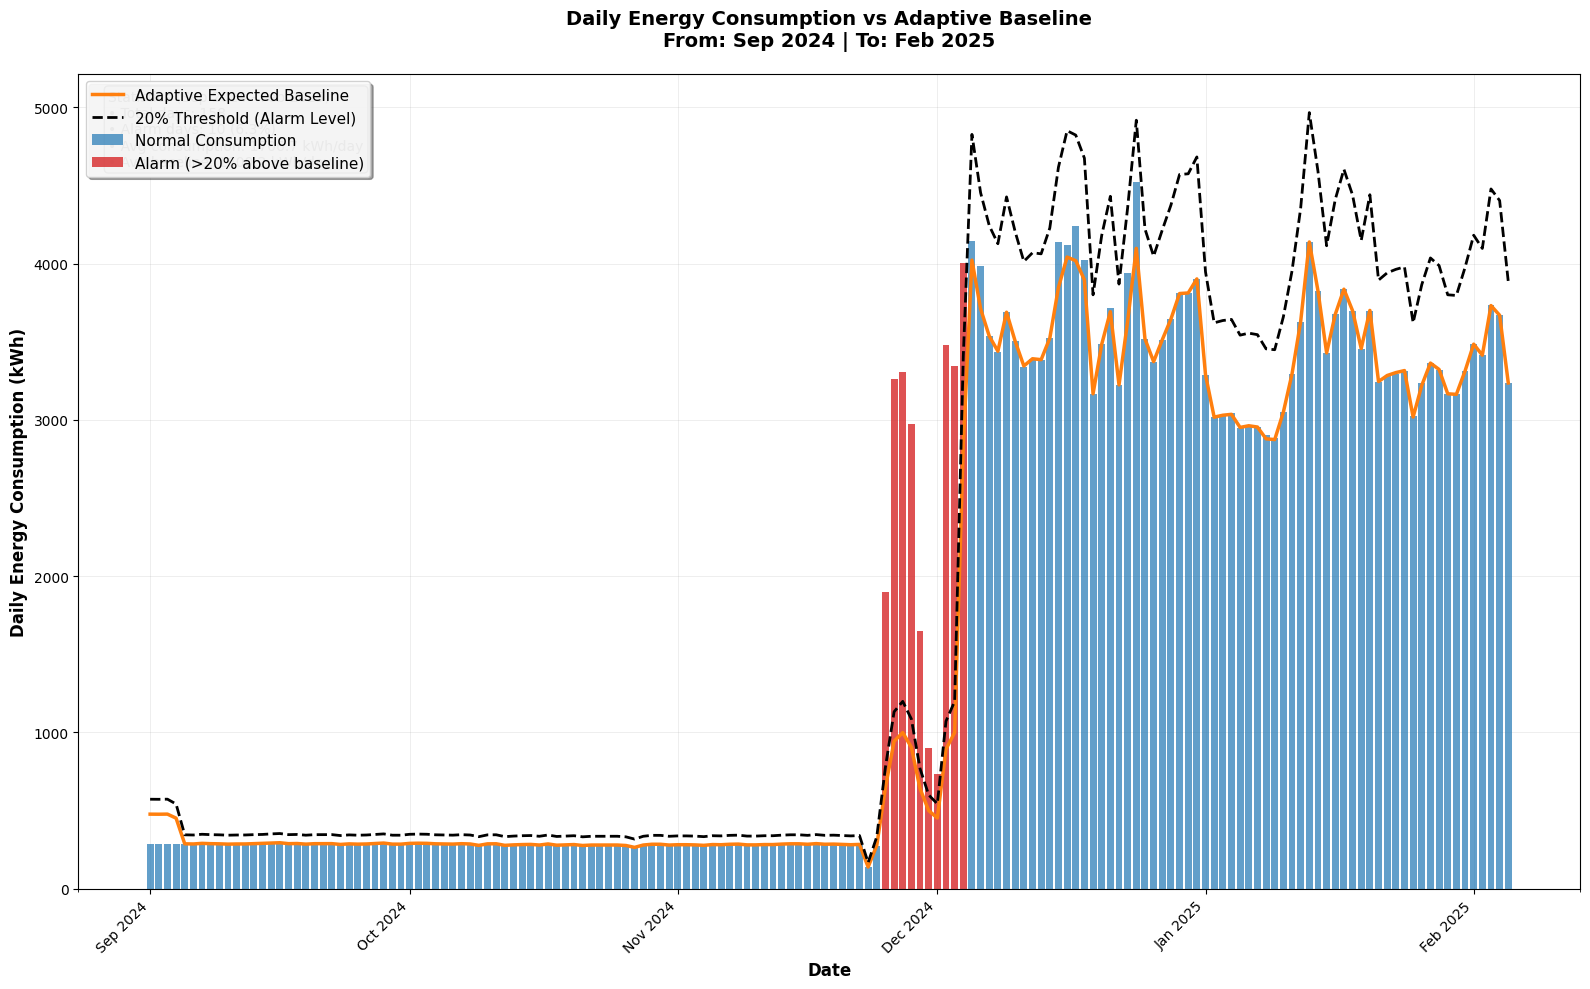


🚨 ALARM PERIOD ANALYSIS (Sep 2024 - Feb 2025):
--------------------------------------------------
Alarm days with highest excess consumption:
  2024-12-02: 3477.0 kWh (baseline: 893.5, +289.1%)
  2024-11-26: 3260.0 kWh (baseline: 943.8, +245.4%)
  2024-12-03: 3346.0 kWh (baseline: 999.3, +234.8%)
  2024-11-27: 3305.0 kWh (baseline: 999.3, +230.7%)
  2024-11-28: 2974.0 kWh (baseline: 905.4, +228.5%)

🎯 FILTERED VISUALIZATION FEATURES:
✅ Date range: Sep 1, 2024 to Feb 5, 2025
✅ X-axis format: 'Sep 2024', 'Oct 2024', etc.
✅ Blue bars: Normal daily consumption
✅ Red bars: Alarm days (>20% above baseline)
✅ Yellow line: Adaptive expected baseline
✅ Black dotted line: 20% alarm threshold
✅ Statistics for filtered period only


In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

print("📊 CREATING FILTERED DAILY CONSUMPTION VISUALIZATION (Sep 2024 - Feb 2025)")
print("=" * 70)

# Read the daily aggregated data
daily_df = pd.read_csv('/Users/vishva.bhatt/Downloads/gds project/xgb_adaptive_model_daily.csv')

# Convert date column to datetime
daily_df['date'] = pd.to_datetime(daily_df['date'])

# Filter data to specified date range
start_date = '2024-09-01'
end_date = '2025-02-05'

filtered_df = daily_df[
    (daily_df['date'] >= start_date) & 
    (daily_df['date'] <= end_date)
].copy()

print(f"Filtered data: {len(filtered_df)} records")
print(f"Date range: {filtered_df['date'].min().date()} to {filtered_df['date'].max().date()}")

if len(filtered_df) == 0:
    print("❌ No data found in the specified date range!")
    print("Available date range in data:")
    print(f"  From: {daily_df['date'].min().date()}")
    print(f"  To: {daily_df['date'].max().date()}")
else:
    # Calculate the 20% threshold above baseline
    filtered_df['threshold_20_percent'] = filtered_df['adaptive_expected_baseline'] * 1.20
    
    # Create alarm condition (actual consumption > 20% above baseline)
    filtered_df['alarm_condition'] = filtered_df['total_consumption'] > filtered_df['threshold_20_percent']
    
    print(f"Alarm days: {filtered_df['alarm_condition'].sum()} out of {len(filtered_df)} ({filtered_df['alarm_condition'].mean()*100:.1f}%)")
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Define colors
    blue_color = '#1f77b4'      # Normal consumption bars (blue)
    red_color = '#d62728'       # Alarm consumption bars (red)
    yellow_color = '#ff7f0e'    # Baseline line (yellow/orange)
    black_color = '#000000'     # Threshold line (black)
    
    # Create bar chart for actual consumption
    # Separate normal and alarm bars
    normal_mask = ~filtered_df['alarm_condition']
    alarm_mask = filtered_df['alarm_condition']
    
    # Plot normal consumption bars (blue)
    if normal_mask.any():
        ax.bar(filtered_df.loc[normal_mask, 'date'], 
               filtered_df.loc[normal_mask, 'total_consumption'],
               color=blue_color, 
               alpha=0.7,
               label='Normal Consumption',
               width=0.8)
    
    # Plot alarm consumption bars (red)
    if alarm_mask.any():
        ax.bar(filtered_df.loc[alarm_mask, 'date'], 
               filtered_df.loc[alarm_mask, 'total_consumption'],
               color=red_color, 
               alpha=0.8,
               label='Alarm (>20% above baseline)',
               width=0.8)
    
    # Plot baseline line (yellow)
    ax.plot(filtered_df['date'], 
            filtered_df['adaptive_expected_baseline'],
            color=yellow_color, 
            linewidth=2.5,
            label='Adaptive Expected Baseline',
            zorder=5)
    
    # Plot threshold line (black dotted)
    ax.plot(filtered_df['date'], 
            filtered_df['threshold_20_percent'],
            color=black_color, 
            linewidth=2,
            linestyle='--',
            label='20% Threshold (Alarm Level)',
            zorder=5)
    
    # Customize the plot
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Daily Energy Consumption (kWh)', fontsize=12, fontweight='bold')
    
    # Create title with date range
    title = f'Daily Energy Consumption vs Adaptive Baseline\n'
    title += f'From: Sep 2024 | To: Feb 2025'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Format x-axis dates - MONTH YEAR FORMAT
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Sep 2024 format
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=7))
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Create legend with custom positioning
    legend = ax.legend(loc='upper left', 
                      frameon=True, 
                      fancybox=True, 
                      shadow=True,
                      fontsize=11,
                      framealpha=0.9)
    
    # Add statistics text box
    stats_text = f'''Statistics (Sep 2024 - Feb 2025):
• Total days: {len(filtered_df):,}
• Alarm days: {filtered_df["alarm_condition"].sum():,} ({filtered_df["alarm_condition"].mean()*100:.1f}%)
• Avg consumption: {filtered_df["total_consumption"].mean():.1f} kWh/day
• Avg baseline: {filtered_df["adaptive_expected_baseline"].mean():.1f} kWh/day'''
    
    # Add text box with statistics
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the plot
    plot_filename = '/Users/vishva.bhatt/Downloads/gds project/daily_consumption_sep2024_feb2025.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight', facecolor='white')
    
    print(f"\n✅ FILTERED VISUALIZATION CREATED!")
    print(f"📁 Saved as: {plot_filename}")
    
    # Show the plot
    plt.show()
    
    # Additional analysis: Show alarm periods in filtered range
    print(f"\n🚨 ALARM PERIOD ANALYSIS (Sep 2024 - Feb 2025):")
    print("-" * 50)
    
    if filtered_df['alarm_condition'].any():
        alarm_days = filtered_df[filtered_df['alarm_condition']].copy()
        alarm_days['excess_pct'] = ((alarm_days['total_consumption'] - alarm_days['adaptive_expected_baseline']) / 
                                   alarm_days['adaptive_expected_baseline']) * 100
        
        print(f"Alarm days with highest excess consumption:")
        top_alarms = alarm_days.nlargest(5, 'excess_pct')[['date', 'total_consumption', 'adaptive_expected_baseline', 'excess_pct']]
        
        for _, row in top_alarms.iterrows():
            print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['total_consumption']:.1f} kWh (baseline: {row['adaptive_expected_baseline']:.1f}, +{row['excess_pct']:.1f}%)")
    else:
        print("No alarm periods found in the filtered date range")
    
    print(f"\n🎯 FILTERED VISUALIZATION FEATURES:")
    print(f"✅ Date range: Sep 1, 2024 to Feb 5, 2025")
    print(f"✅ X-axis format: 'Sep 2024', 'Oct 2024', etc.")
    print(f"✅ Blue bars: Normal daily consumption")
    print(f"✅ Red bars: Alarm days (>20% above baseline)")
    print(f"✅ Yellow line: Adaptive expected baseline")
    print(f"✅ Black dotted line: 20% alarm threshold")
    print(f"✅ Statistics for filtered period only")

In [ ]:
%pip install "nbformat>=4.2.0"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


• Use the range selectors to focus on specific time periods


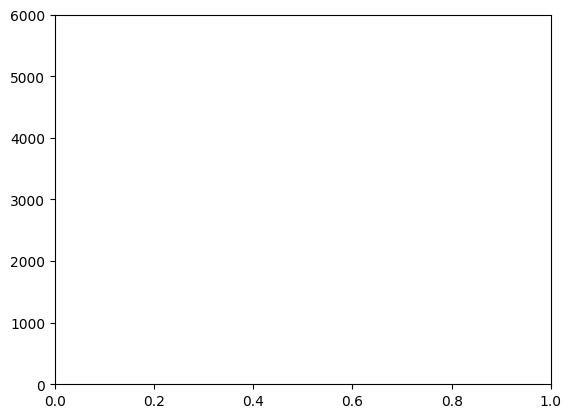

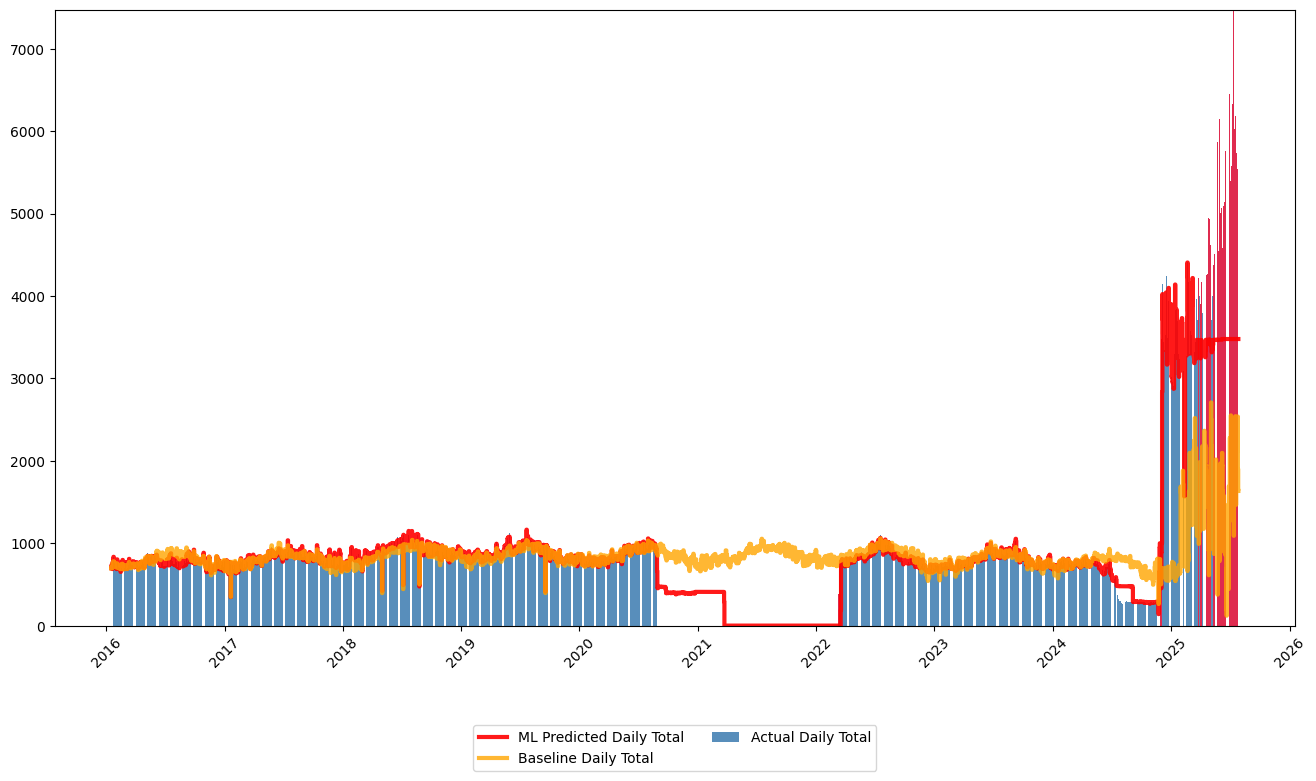

In [36]:
%pip install plotly
import plotly.graph_objects as go

# Read the daily aggregated data
daily_df = pd.read_csv('/Users/vishva.bhatt/Downloads/gds project/xgb_adaptive_model_daily.csv')

# Convert date column to datetime
daily_df['date'] = pd.to_datetime(daily_df['date'])

# Aggregate daily data
daily_df = daily_df.groupby('date').agg(
    VALUE=('total_consumption', 'sum'),
    predictions=('adaptive_expected_baseline', 'mean'),
    baseline=('reference', 'mean')
).reset_index()

# Calculate anomalies (actual consumption > 20% higher than prediction)
daily_df['anomaly'] = daily_df['VALUE'] > (daily_df['predictions'] * 1.20)

# Interactive daily plot with Plotly - Bars for actual, step lines for predictions
fig_daily = go.Figure()

# Create color array for bars: red for anomalies, blue for normal
bar_colors = ['rgba(220, 20, 60, 0.9)' if anomaly else 'rgba(70, 130, 180, 0.9)' 
              for anomaly in daily_df['anomaly']]

bar_colors = ['rgba(220, 20, 60, 0.9)' if anomaly else 'rgba(70, 130, 180, 0.9)' 
              for anomaly in daily_df['anomaly']]

# Add actual daily consumption as bars with conditional coloring
fig_daily.add_trace(go.Bar(
    x=daily_df['date'],
    y=daily_df['VALUE'],
    name='Actual Daily Total',
    marker_color=bar_colors,
    opacity=1.0,  # Full opacity for better visibility when zoomed out
    hovertemplate='<b>Actual Daily Total</b><br>Date: %{x}<br>Total: %{y:.2f} kWh<br>Anomaly: %{customdata}<extra></extra>',
    customdata=['Yes (>20% above prediction)' if anomaly else 'No' for anomaly in daily_df['anomaly']]
))

# Add 20% threshold line to Plotly figure (black dotted)
fig_daily.add_trace(go.Scatter(
    x=daily_df['date'],
    y=daily_df['predictions'] * 1.20,
    mode='lines',
    name='20% Threshold (Alarm Level)',
    line=dict(color='black', width=2, dash='dot'),
    opacity=0.7,
    hovertemplate='<b>20% Threshold</b><br>Date: %{x}<br>Threshold: %{y:.2f} kWh<extra></extra>'
))

# Add predicted daily consumption as step line
fig_daily.add_trace(go.Scatter(
    x=daily_df['date'],
    y=daily_df['predictions'],
    mode='lines',
    name='ML Predicted Daily Total',
    line=dict(color='black', width=3, shape='hv'),  # step-style line
    opacity=0.9,
    hovertemplate='<b>ML Predicted Daily Total</b><br>Date: %{x}<br>Total: %{y:.2f} kWh<extra></extra>'
))

# Add baseline daily consumption as step line if available
if daily_df['baseline'].notna().sum() > 0:
    fig_daily.add_trace(go.Scatter(
        x=daily_df['date'],
        y=daily_df['baseline'],
        mode='lines',
        name='Baseline Daily Total',
        line=dict(color='orange', width=3, shape='hv'),  # step-style line
        opacity=0.8,
        hovertemplate='<b>Baseline Daily Total</b><br>Date: %{x}<br>Total: %{y:.2f} kWh<extra></extra>'
    ))

# Set layout for the Plotly figure
fig_daily.update_layout(
    title={
        'text': 'Daily Energy Consumption vs Adaptive Baseline<br><sub>Red bars indicate anomalies (&gt;20% above prediction), blue bars are normal consumption</sub>',
        'x': 0.5,
        'font': {'size': 16}
    },
    xaxis_title='Date',
    yaxis_title='Total Daily Energy Consumption (kWh)',
    yaxis=dict(
        range=[0, 5500], 
        fixedrange=False,
        rangemode='tozero'
    ),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1M", step="month", stepmode="backward"),
                dict(count=3, label="3M", step="month", stepmode="backward"),
                dict(count=6, label="6M", step="month", stepmode="backward"),
                dict(count=1, label="1Y", step="year", stepmode="backward"),
                dict(count=2, label="2Y", step="year", stepmode="backward"),
                dict(step="all", label="All")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date",
        range=["2024-09-01","2025-02-05"]
    ),
    hovermode='x unified',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    width=1200,
    height=600,
    template='plotly_white',
    uirevision='constant',
    # Clean up the plot appearance
    plot_bgcolor='white',
    showlegend=True
)

fig_daily.show()

plt.ylim(0, 6000)

# Static matplotlib version for daily aggregation - Bars and step lines
plt.figure(figsize=(16, 8))

# Create color array for bars: red for anomalies, blue for normal
bar_colors = ['crimson' if anomaly else 'steelblue' for anomaly in daily_df['anomaly']]

# Plot actual daily consumption as bars with conditional coloring
plt.bar(daily_df['date'], daily_df['VALUE'], 
         color=bar_colors, alpha=0.9, label='Actual Daily Total', width=0.8)

# Plot predicted daily consumption as step line
plt.step(daily_df['date'], daily_df['predictions'], 
         color='red', linewidth=3, label='ML Predicted Daily Total', alpha=0.9, where='mid')

# Plot baseline daily consumption as step line if available
if daily_df['baseline'].notna().sum() > 0:
    plt.step(daily_df['date'], daily_df['baseline'], 
             color='orange', linewidth=3, label='Baseline Daily Total', alpha=0.8, where='mid')
plt.xticks(rotation=45)

# Position legend below the graph
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize=10)


# Auto-adjust y-axis based on daily data range
y_values = [daily_df['VALUE'], daily_df['predictions']]
if daily_df['baseline'].notna().sum() > 0:
    y_values.append(daily_df['baseline'])
y_min = min([v.min() for v in y_values])
y_max = max([v.max() for v in y_values])
plt.ylim(y_min * 0.95, y_max * 0.95)  # Add 5% padding
print("• Use the range selectors to focus on specific time periods")

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 6.4 MB/s  eta 0:00:01
     |████████████████████████████████| 354 kB 11.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
